## Prepare Dependencies and Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from natsort import natsorted
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CopulaGANSynthesizer, CTGANSynthesizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import glob
from sklearn.manifold import TSNE
import umap
from sklearn.metrics.pairwise import rbf_kernel
import warnings
warnings.filterwarnings("ignore")

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Read Dataset

In [3]:
fused_swin = pd.read_csv('dataset/swin_fused.csv')
fused_cait = pd.read_csv('dataset/cait_fused.csv')
fused_coatnet = pd.read_csv('dataset/coatnet_fused.csv')
fused_yolov9 = pd.read_csv('dataset/yolov9_fused.csv')

In [4]:
fused_swin.isna().sum().sum()

0

In [5]:
fused_swin.head()

,0,1,2,3,4,5,6,7,8,9,...,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
0,-0.506028,-0.306852,0.211196,-0.260530,0.831871,0.162391,0.393585,-0.171429,0.340640,0.698110,...,67.0,0.0,5.0,3.0,315.0,11.0,3.0,300.0,1.0,0
1,0.064806,-0.370467,-0.139201,-0.038765,1.311397,-0.743221,0.065842,-0.021887,0.011268,0.294051,...,65.0,0.0,11.0,3.0,345.0,17.0,3.0,100.0,2.0,0
2,-0.457242,0.038379,0.287351,0.081722,0.180021,-0.211764,-0.230158,-0.435847,-0.075014,-0.617530,...,65.0,0.0,17.0,3.0,255.0,21.0,3.0,0.0,3.0,0
3,-0.588846,0.403877,-0.015955,0.072322,1.048142,-0.587832,-0.169320,0.479973,0.468464,0.205951,...,65.0,0.0,21.0,3.0,465.0,5.0,4.0,150.0,0.0,0
4,-0.217971,0.376933,-0.054559,-0.053777,1.210200,-0.577169,0.307845,0.330822,0.361465,0.621866,...,70.0,0.0,21.0,3.0,510.0,5.0,4.0,400.0,0.0,0


In [6]:
fused_swin.iloc[:,-16:]

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
0,15.0,1500.0,1800.0,52.000,134.0,85.0,67.0,0.0,5.0,3.0,315.0,11.0,3.0,300.0,1.0,0
1,15.0,1500.0,1600.0,51.000,136.0,96.0,65.0,0.0,11.0,3.0,345.0,17.0,3.0,100.0,2.0,0
2,15.0,1500.0,1500.0,51.000,136.0,96.0,65.0,0.0,17.0,3.0,255.0,21.0,3.0,0.0,3.0,0
3,15.0,1500.0,1650.0,51.000,136.0,96.0,65.0,0.0,21.0,3.0,465.0,5.0,4.0,150.0,0.0,0
4,15.0,1500.0,1900.0,51.000,130.0,90.0,70.0,0.0,21.0,3.0,510.0,5.0,4.0,400.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,5.0,1000.0,1176.0,68.655,166.0,104.0,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0,1
461,5.0,1000.0,1122.0,69.345,170.0,106.0,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0,1
462,5.0,1000.0,1078.0,68.655,166.0,104.0,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0,1
463,5.0,1000.0,1377.0,52.260,139.0,81.0,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0,1


In [7]:
fused_swin.iloc[:,-16:]

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
0,15.0,1500.0,1800.0,52.000,134.0,85.0,67.0,0.0,5.0,3.0,315.0,11.0,3.0,300.0,1.0,0
1,15.0,1500.0,1600.0,51.000,136.0,96.0,65.0,0.0,11.0,3.0,345.0,17.0,3.0,100.0,2.0,0
2,15.0,1500.0,1500.0,51.000,136.0,96.0,65.0,0.0,17.0,3.0,255.0,21.0,3.0,0.0,3.0,0
3,15.0,1500.0,1650.0,51.000,136.0,96.0,65.0,0.0,21.0,3.0,465.0,5.0,4.0,150.0,0.0,0
4,15.0,1500.0,1900.0,51.000,130.0,90.0,70.0,0.0,21.0,3.0,510.0,5.0,4.0,400.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,5.0,1000.0,1176.0,68.655,166.0,104.0,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0,1
461,5.0,1000.0,1122.0,69.345,170.0,106.0,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0,1
462,5.0,1000.0,1078.0,68.655,166.0,104.0,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0,1
463,5.0,1000.0,1377.0,52.260,139.0,81.0,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0,1


## Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

fused_data_dict = {
    "swin": fused_swin,
    "cait": fused_cait,
    "coatnet": fused_coatnet,
    "yolov9": fused_yolov9
}

# Dictionary hasil split
split_real_data = {}

for model_name, df in fused_data_dict.items():
    # df = df.copy()  # Hindari modify df asli

    # Simpan index asli ke kolom
    # df["original_index"] = df.index

    X = df.drop(columns=["label"])
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    split_real_data[model_name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

In [9]:
split_real_data['swin'].keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [10]:
split_real_data['swin']['X_train']

,0,1,2,3,4,5,6,7,8,9,...,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
164,-0.804540,-0.628833,-0.284558,-0.009834,1.551378,0.335542,-0.404450,0.056312,0.297985,0.891328,...,80.0,62.0,0.0,22.0,3.0,460.0,6.0,4.0,630.0,0.0
22,-0.097215,-0.124580,0.135851,-0.173689,0.830869,-0.477185,-0.133811,0.212834,0.129199,0.473550,...,101.0,70.0,0.0,22.0,3.0,405.0,5.0,4.0,600.0,0.0
177,-0.951763,-0.436604,0.659387,0.806011,1.029135,0.706624,0.127434,0.184788,-0.400599,0.701593,...,78.0,84.0,0.0,11.0,3.0,334.0,16.0,3.0,620.0,3.0
55,-0.467182,-0.265221,0.323412,-0.176633,0.676746,0.913738,0.566468,0.526103,0.010158,-0.045068,...,61.0,106.0,1.0,5.0,3.0,295.0,10.0,3.0,250.0,1.0
19,-0.339253,-0.028781,-0.022939,0.141566,0.653280,0.371804,-0.200022,0.240468,0.243082,0.835351,...,101.0,70.0,0.0,5.0,3.0,315.0,11.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.310944,0.035290,-0.171590,-0.063037,1.006162,0.949149,0.746082,0.136041,0.476429,0.435178,...,100.0,80.0,1.0,6.0,3.0,280.0,11.0,3.0,342.2,1.0
452,-0.173914,0.180067,-0.247749,0.059692,1.242757,-0.845190,0.353989,0.293445,-0.591633,0.328925,...,84.0,64.0,0.0,21.0,3.0,467.0,5.0,4.0,156.0,0.0
152,-0.230420,0.582163,0.364871,-0.182426,0.565522,0.170268,0.387821,0.021462,0.283322,0.149940,...,58.0,78.0,0.0,10.0,3.0,57.0,11.0,3.0,200.0,1.0
42,0.111567,0.143492,-0.133476,-0.168867,0.627179,0.199200,-0.561805,-0.365087,-0.119726,-0.082295,...,87.0,70.0,0.0,21.0,3.0,465.0,5.0,4.0,100.0,0.0


In [11]:
split_real_data['swin']['y_test'].value_counts()

label
0    86
1    31
Name: count, dtype: int64

## PCA

In [12]:
from sklearn.decomposition import PCA

pca_results = {}

for model_name, data in split_real_data.items():
    
    print(f"\n=== {model_name.upper()} ===")

    # Ambil X dan y dari split
    X_train = data['X_train']
    y_train = data['y_train']

    # Simpan original index dulu
    # original_indices_train = X_train['original_index'].values

    # # Drop kolom original_index sebelum PCA
    # X_train = X_train.drop(columns=["original_index"])

    # Pisahkan fitur extraction dan tabular (misalnya, 16 kolom terakhir adalah tabular)
    X_train_feat = X_train.iloc[:, :-16]  # fitur hasil feature extraction
    X_train_tabular = X_train.iloc[:, -16:]  # data tabular

    print(X_train_feat.isna().sum().sum())
    print(X_train_tabular.isna().sum().sum())

    # Fit PCA di X_train
    pca_used = PCA(n_components=0.85, random_state=42)
    X_train_pca = pca_used.fit_transform(X_train_feat)

    # Gabungkan hasil PCA dengan fitur tabular untuk X_train
    X_train_comb = pd.concat([pd.DataFrame(X_train_pca), X_train_tabular.reset_index(drop=True)], axis=1)

    # Simpan hasil PCA
    pca_results[model_name] = {
        'pca': pca_used,
        'X_train': X_train_comb,
        'y_train': y_train
    }

    # Print summary
    total_var = pca_used.explained_variance_ratio_.sum()
    print(f"Total variance captured: {total_var:.2%}")
    print(f"Number of PCA components selected: {pca_used.n_components_}")



=== SWIN ===
0
0
Total variance captured: 85.03%
Number of PCA components selected: 81

=== CAIT ===
0
0
Total variance captured: 85.25%
Number of PCA components selected: 67

=== COATNET ===
0
0
Total variance captured: 85.13%
Number of PCA components selected: 237

=== YOLOV9 ===
0
0
Total variance captured: 85.10%
Number of PCA components selected: 205


In [13]:
import joblib

for model_name in pca_results:
    pca_model = pca_results[model_name]['pca']
    joblib.dump(pca_model, f"pca_{model_name}.pkl")
    print(f"✅ PCA untuk model {model_name} disimpan sebagai pca_{model_name}.pkl")

✅ PCA untuk model swin disimpan sebagai pca_swin.pkl
✅ PCA untuk model cait disimpan sebagai pca_cait.pkl
✅ PCA untuk model coatnet disimpan sebagai pca_coatnet.pkl
✅ PCA untuk model yolov9 disimpan sebagai pca_yolov9.pkl


## Sequential Synthetic Data Generation

In [19]:
train_df_dict = {}

for model_name, result in pca_results.items():
    X = result["X_train"].copy()
    y = result["y_train"].reset_index(drop=True)

    # Gabungkan X dan y
    train_df = X.copy()
    train_df["label"] = y
    train_df_dict[model_name] = train_df

In [14]:
train_df_dict.keys()

dict_keys(['swin', 'cait', 'coatnet', 'yolov9'])

In [15]:
train_df_dict['swin'].isna().sum().sum()

0

In [20]:
minority_data_dict = {}
majority_data_dict = {}

for model_name, df in train_df_dict.items():
    # label 1 = minority (abnormal), 0 = majority (normal)
    minority_df = df[df['label'] == 1].reset_index(drop=True)
    majority_df = df[df['label'] == 0].reset_index(drop=True)

    minority_data_dict[model_name] = minority_df
    majority_data_dict[model_name] = majority_df

    print(f"{model_name}: {len(minority_df)} minority, {len(majority_df)} majority")

swin: 92 minority, 256 majority
cait: 92 minority, 256 majority
coatnet: 92 minority, 256 majority
yolov9: 92 minority, 256 majority


In [ ]:
categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
integer_columns = ['durasi_drain_menit', 'volume_masuk', 'jam_masuk', 'dwell_time_menit', 'jam_keluar']
numeric_columns = [col for col in minority_df.columns if (col not in categorical_columns) and (col not in integer_columns)]
# numeric_columns = [col for col in minority_df.columns if col not in categorical_columns]

In [18]:
not_integer_count = (~minority_data_dict['swin'][integer_columns].applymap(lambda x: float(x).is_integer())).sum()
print(not_integer_count)


durasi_drain_menit    0
volume_masuk          0
jam_masuk             0
dwell_time_menit      0
jam_keluar            0
dtype: int64


In [16]:
len(majority_data_dict['swin'])-len(minority_data_dict['swin'])

164

### CTGAN

#### Generate

In [17]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctgan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [18]:
synthetic_data_dict_ctgan = {}
ctgan_loss_dict = {}

for model_name, train_df in minority_data_dict.items():
    print(f"Proses CTGAN untuk model: {model_name}")

    # Inisialisasi metadata dan deteksi kolom kategorikal
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(train_df)

    # Update kolom kategorikal jika perlu
    categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
    for col in categorical_columns:
        metadata.update_column(column_name=col, sdtype='categorical')

    # Inisialisasi dan latih CTGAN
    synthesizer = CTGANSynthesizer(
        metadata=metadata,
        epochs=500,
        batch_size=20,
        generator_dim=(128, 128),
        discriminator_dim=(128, 128),
        pac=10,
        verbose=True
    )
    synthesizer.fit(train_df)

    # Simpan nilai loss
    loss_values = synthesizer.get_loss_values()
    ctgan_loss_dict[model_name] = loss_values

    # Generate synthetic data sebanyak data majority
    synthetic_data = synthesizer.sample(len(majority_data_dict[model_name]-len(minority_data_dict[model_name])))
    synthetic_df = pd.DataFrame(synthetic_data, columns=train_df.columns).copy()

    # Simpan synthetic data
    synthetic_df.to_csv(os.path.join(output_dir, f"{model_name}_fake.csv"), index=False)

    synthetic_data_dict_ctgan[model_name] = synthetic_df
    print(f"Synthetic data untuk model {model_name} berhasil dibuat.")

Proses CTGAN untuk model: swin
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27                     11
28                     11
29                   

Gen. (-4.85) | Discrim. (-0.80): 100%|██████████| 500/500 [02:10<00:00,  3.83it/s]


Synthetic data untuk model swin berhasil dibuat.
Proses CTGAN untuk model: cait


Gen. (-1.45) | Discrim. (2.54): 100%|██████████| 500/500 [01:54<00:00,  4.38it/s]  


Synthetic data untuk model cait berhasil dibuat.
Proses CTGAN untuk model: coatnet
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27                   

Gen. (-7.63) | Discrim. (-3.50): 100%|██████████| 500/500 [05:17<00:00,  1.58it/s]  


Synthetic data untuk model coatnet berhasil dibuat.
Proses CTGAN untuk model: yolov9
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27                 

Gen. (-18.73) | Discrim. (-12.69): 100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


Synthetic data untuk model yolov9 berhasil dibuat.


In [ ]:
synthetic_data_dict_ctgan.keys()

In [19]:
synthetic_data_dict_ctgan = {}
combined_data_dict_ctgan = {}

synthetic_path = 'dataset/synthetic_real/pca-85-percent/ctgan/synthetic/'

for model_name in minority_data_dict.keys():
    synthetic_data_dict_ctgan[model_name] = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake.csv"))

In [20]:
combined_data_dict_ctgan = {}

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_ctgan[model_name]

    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_ctgan[model_name] = combined_df

In [ ]:
combined_data_dict_ctgan['swin'][combined_data_dict_ctgan['swin']['label']==1]

In [ ]:
combined_data_dict_ctgan['swin'][combined_data_dict_ctgan['swin']['label']==0]

In [ ]:
combined_data_dict_ctgan['swin'].duplicated().sum()

In [21]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctgan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

Data untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/swin_combined.csv
Data untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/cait_combined.csv
Data untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/coatnet_combined.csv
Data untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/yolov9_combined.csv


#### Evaluasi

In [22]:
loss_folder_path = 'dataset/synthetic_real/pca-85-percent/ctgan/'

for model_name, loss_values in ctgan_loss_dict.items():

    file_path = os.path.join(loss_folder_path, f"{model_name}_loss.csv")
    loss_df = pd.DataFrame(loss_values, columns=['loss'])

    loss_df.to_csv(file_path, index=False)
    print(f"Loss untuk model {model_name} telah disimpan di {file_path}")

Loss untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/swin_loss.csv
Loss untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/cait_loss.csv
Loss untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/coatnet_loss.csv
Loss untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/ctgan/yolov9_loss.csv


In [ ]:
ctgan_loss_dict.keys()

In [ ]:
ctgan_loss_dict['swin']

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### CTAB-Plus-GAN

#### prepare

In [32]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics

#### generate

In [33]:
num_exp = 1
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctabganplus/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
output_dir

In [58]:
for model_name in minority_data_dict.keys():
    minority_df = minority_data_dict[model_name].copy()
    majority_df = majority_data_dict[model_name].copy()
    minority_df[integer_columns] = minority_df[integer_columns].astype(int)
    majority_df[integer_columns] = majority_df[integer_columns].astype(int)


    print(f"{model_name}: Generating Synthetic Data")

    synthesizer = CTABGAN(
        raw_data=minority_df,
        test_ratio=0.20,
        categorical_columns=categorical_columns,
        log_columns=[],
        mixed_columns={},
        general_columns=[],
        non_categorical_columns=numeric_columns,
        integer_columns=integer_columns,
        problem_type={"Classification": 'label'},
        len_generated= len(majority_df)-len(minority_df)
    )

    for i in range(num_exp):
        synthesizer.fit()
        syn = synthesizer.generate_samples()
        syn.to_csv(os.path.join(output_dir, f"{model_name}_fake_{i}.csv"), index=False)


swin: Generating Synthetic Data


100%|██████████| 150/150 [00:36<00:00,  4.15it/s]


Finished training in 41.02452564239502  seconds.
cait: Generating Synthetic Data


100%|██████████| 150/150 [00:32<00:00,  4.66it/s]


Finished training in 36.08762073516846  seconds.
coatnet: Generating Synthetic Data


100%|██████████| 150/150 [01:24<00:00,  1.78it/s]


Finished training in 97.51663517951965  seconds.
yolov9: Generating Synthetic Data


100%|██████████| 150/150 [01:19<00:00,  1.88it/s]


Finished training in 91.25221276283264  seconds.


In [59]:
synthetic_data_dict_ctabplusgan = {}
combined_data_dict_ctabplusgan = {}

synthetic_path = 'dataset/synthetic_real/pca-85-percent/ctabganplus/synthetic/'

# Kumpulkan data sintetis untuk setiap model
for model_name in minority_data_dict.keys():
    synthetic_dfs = []

    for i in range(num_exp):
        file_path = os.path.join(synthetic_path, f"{model_name}_fake_{i}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            synthetic_dfs.append(df)
        else:
            print(f"[WARNING] File not found: {file_path}")

    if synthetic_dfs:
        synthetic_data_dict_ctabplusgan[model_name] = pd.concat(synthetic_dfs, ignore_index=True)
    else:
        print(f"[WARNING] No synthetic data found for model: {model_name}")

# Gabungkan dengan data real
for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]

    if model_name in synthetic_data_dict_ctabplusgan:
        synthetic_df = synthetic_data_dict_ctabplusgan[model_name]

        # Samakan nama dan urutan kolom
        synthetic_df.columns = real_df.columns
        synthetic_df = synthetic_df[real_df.columns]

        # Gabungkan
        combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)
        combined_data_dict_ctabplusgan[model_name] = combined_df
    else:
        print(f"[INFO] Skipping model {model_name} — no synthetic data available.")


In [ ]:
combined_data_dict_ctabplusgan['swin']

In [60]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctabganplus/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctabplusgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

Data untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/ctabganplus/swin_combined.csv
Data untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/ctabganplus/cait_combined.csv
Data untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/ctabganplus/coatnet_combined.csv
Data untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/ctabganplus/yolov9_combined.csv


#### evaluasi

In [ ]:
synthetic_path = 'dataset/synthetic_real/standard-scaler-85-percent/ctabganplus/synthetic/'

In [ ]:
os.listdir(synthetic_path)

In [ ]:
all_files = os.listdir(synthetic_path)

fake_paths_all = {}

for file in all_files:
    for model_name in train_df_dict.keys():
        if model_name in file: 
            if model_name not in fake_paths_all:
                fake_paths_all[model_name] = []
            fake_paths_all[model_name].append(os.path.join(synthetic_path, file))

# Print hasil untuk memastikan
print(fake_paths_all)


In [ ]:
output_dir = synthetic_path = 'dataset/synthetic_real/standard-scaler-85-percent/ctabganplus/synthetic/'

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctabplusgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### CTAB GAN

#### Prepare

In [19]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics

#### Generate

In [20]:
num_exp = 1
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctabgan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
minority_data_dict['coatnet'].isna().sum().sum()

In [ ]:
minority_data_dict['coatnet'].shape

In [ ]:
minority_data_dict['coatnet'].iloc[:, -16:]

In [ ]:
minority_data_dict['coatnet']

In [ ]:
minority_data_dict['yolov9']

In [21]:
for model_name in minority_data_dict.keys():
    minority_df = minority_data_dict[model_name]
    majority_df = majority_data_dict[model_name]
    minority_df[integer_columns] = minority_df[integer_columns].astype(int)
    majority_df[integer_columns] = majority_df[integer_columns].astype(int)


    print(f"{model_name}: Generating Synthetic Data using CTAB-GAN")

    # numeric_columns = [col for col in minority_df.columns if col not in categorical_columns]

    synthesizer =  CTABGAN(
                  raw_data = minority_df,
                  test_ratio = 0.20,
                  categorical_columns = categorical_columns,
                  log_columns = [],
                  mixed_columns= {},
                  integer_columns = integer_columns,
                  problem_type= {"Classification": 'label'},
                  epochs = 150,
                  len_generated=len(majority_df) - len(minority_df)
              )

    # Fitting the synthesizer to the training dataset and generating synthetic data
    for i in range(num_exp):
        synthesizer.fit()
        syn = synthesizer.generate_samples()
        syn.to_csv(os.path.join(output_dir, f"{model_name}_fake_{i}.csv"), index=False)


swin: Generating Synthetic Data using CTAB-GAN


100%|██████████| 150/150 [00:17<00:00,  8.78it/s]


Finished training in 22.57632875442505  seconds.
cait: Generating Synthetic Data using CTAB-GAN


100%|██████████| 150/150 [00:15<00:00,  9.49it/s]


Finished training in 19.89455246925354  seconds.
coatnet: Generating Synthetic Data using CTAB-GAN


100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


Finished training in 50.996225357055664  seconds.
yolov9: Generating Synthetic Data using CTAB-GAN


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]

Finished training in 46.75041604042053  seconds.


In [22]:
synthetic_data_dict_ctabgan = {}
combined_data_dict_ctabgan = {}

synthetic_path = 'dataset/synthetic_real/pca-85-percent/ctabgan/synthetic/'

for model_name in minority_data_dict.keys():
    synthetic_data_dict_ctabgan[model_name] = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake_0.csv"))


for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_ctabgan[model_name]

    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_ctabgan[model_name] = combined_df

In [23]:
combined_data_dict_ctabgan['swin'].isna().sum().sum()

0

In [24]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/ctabgan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctabgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

Data untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/ctabgan/swin_combined.csv
Data untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/ctabgan/cait_combined.csv
Data untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/ctabgan/coatnet_combined.csv
Data untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/ctabgan/yolov9_combined.csv


#### Evaluasi

In [ ]:
output_dir = 'dataset/synthetic_real/robust-scaler-85-percent/ctabgan/synthetic/'

In [ ]:
privacy_results = {}
for model in minority_data_dict.keys():
  fake_path = os.path.join(output_dir, f"{model}_fake_0.csv")
  # Specifying the list of classifiers to conduct ML utility evaluation
  classifiers_list = ["lr","dt","rf","mlp","svm"]

  # Storing and presenting the results as a dataframe
  # stat_res = stat_sim(minority_data_dict[model],fake_path,categorical_columns)
  # stat_columns = ["WD (Continuous Columns","JSD (Categorical Columns)","Correlation Distance"]
  # stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)

  priv_res = privacy_metrics(minority_data_dict[model],fake_path)
  privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
  privacy_results[model] = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)

In [ ]:
# for model in minority_data_dict.keys():
#   print('=================================')
#   print(f'utility metrics model: {model}')
#   result_df
#   print('\n')

In [ ]:
for model in minority_data_dict.keys():
  print('=================================')
  print(f'stat metrics model: {model}')
  stat_results
  print('\n')

In [ ]:
privacy_results['swin']

In [ ]:
privacy_results['cait']

In [ ]:
privacy_results['coatnet']

In [ ]:
privacy_results['yolov9']

In [ ]:
synthetic_data_dict_ctabgan = {}
for model in minority_data_dict.keys():
  synthetic_data_dict_ctabgan[model] = pd.read_csv(os.path.join(output_dir, f"{model}_fake_0.csv"))

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctabgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### Copula GAN

#### Generate

In [23]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/copulagan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [24]:
synthetic_data_dict_copulagan = {}
copulagan_loss_dict = {}

for model_name, train_df in minority_data_dict.items():
    print(f"Proses Copula GAN untuk model: {model_name}")

    # Inisialisasi metadata dan deteksi kolom kategorikal
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(train_df)

    # Update kolom kategorikal jika perlu
    categorical_columns = ['volume_masuk', 'jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
    for col in categorical_columns:
        metadata.update_column(column_name=col, sdtype='categorical')

    # Inisialisasi dan latih CTGAN
    synthesizer = CopulaGANSynthesizer(
        metadata=metadata,
        epochs=500,
        verbose=True
    )
    synthesizer.fit(train_df)

    # Simpan nilai loss
    loss_values = synthesizer.get_loss_values()
    copulagan_loss_dict[model_name] = loss_values

    # Generate synthetic data sebanyak data majority
    synthetic_data = synthesizer.sample(len(majority_data_dict[model_name]) - len(minority_data_dict[model_name]))
    synthetic_df = pd.DataFrame(synthetic_data, columns=train_df.columns).copy()

    # Simpan synthetic data
    synthetic_df.to_csv(os.path.join(output_dir, f"{model_name}_fake.csv"), index=False)

    synthetic_data_dict_copulagan[model_name] = synthetic_df
    print(f"Synthetic data untuk model {model_name} berhasil dibuat.")

Proses Copula GAN untuk model: swin
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27                     11
28                     11
29              

Gen. (6.46) | Discrim. (0.20): 100%|██████████| 500/500 [00:35<00:00, 13.92it/s] 


Synthetic data untuk model swin berhasil dibuat.
Proses Copula GAN untuk model: cait


Gen. (3.53) | Discrim. (-0.07): 100%|██████████| 500/500 [00:31<00:00, 16.05it/s]


Synthetic data untuk model cait berhasil dibuat.
Proses Copula GAN untuk model: coatnet
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27              

Gen. (6.83) | Discrim. (0.82): 100%|██████████| 500/500 [01:29<00:00,  5.59it/s] 


Synthetic data untuk model coatnet berhasil dibuat.
Proses Copula GAN untuk model: yolov9
PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27            

Gen. (3.65) | Discrim. (-0.42): 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]


Synthetic data untuk model yolov9 berhasil dibuat.


In [25]:
synthetic_data_dict_copulagan = {}
combined_data_dict_copulagan = {}

synthetic_path = 'dataset/synthetic_real/pca-85-percent/copulagan/synthetic/'

for model_name in minority_data_dict.keys():
    synthetic_data_dict_copulagan[model_name] = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake.csv"))

In [26]:
combined_data_dict_copulagan = {}

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_copulagan[model_name]

    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_copulagan[model_name] = combined_df

In [27]:
drive_folder_path = 'dataset/synthetic_real/pca-85-percent/copulagan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_copulagan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

Data untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/swin_combined.csv
Data untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/cait_combined.csv
Data untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/coatnet_combined.csv
Data untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/yolov9_combined.csv


#### Evaluasi

In [28]:
loss_folder_path = 'dataset/synthetic_real/pca-85-percent/copulagan/'

for model_name, loss_values in copulagan_loss_dict.items():

    file_path = os.path.join(loss_folder_path, f"{model_name}_loss.csv")
    loss_df = pd.DataFrame(loss_values, columns=['loss'])

    loss_df.to_csv(file_path, index=False)
    print(f"Loss untuk model {model_name} telah disimpan di {file_path}")

Loss untuk model swin telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/swin_loss.csv
Loss untuk model cait telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/cait_loss.csv
Loss untuk model coatnet telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/coatnet_loss.csv
Loss untuk model yolov9 telah disimpan di dataset/synthetic_real/pca-85-percent/copulagan/yolov9_loss.csv


In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_copulagan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

## Iterative Synthetic Data Generation

In [ ]:
train_df_dict = {}

for model_name, result in pca_results.items():
    X = result["X_train"].copy()
    y = result["y_train"].reset_index(drop=True)

    # Gabungkan X dan y
    train_df = X.copy()
    train_df["label"] = y
    train_df_dict[model_name] = train_df

In [ ]:
minority_data_dict = {}
majority_data_dict = {}

for model_name, df in train_df_dict.items():
    # label 1 = minority (abnormal), 0 = majority (normal)
    minority_df = df[df['label'] == 1].reset_index(drop=True)
    majority_df = df[df['label'] == 0].reset_index(drop=True)

    minority_data_dict[model_name] = minority_df
    majority_data_dict[model_name] = majority_df

    print(f"{model_name}: {len(minority_df)} minority, {len(majority_df)} majority")

In [ ]:
categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
integer_columns = ['durasi_drain_menit', 'volume_masuk', 'volume_keluar', 'jam_masuk', 'dwell_time_menit', 'jam_keluar', 'selisih_volume']
numeric_columns = [col for col in minority_df.columns if (col not in categorical_columns) and (col not in integer_columns)]

In [ ]:
len(majority_data_dict['swin'])

### CTGAN

#### Generate

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(minority_data_dict['swin'])

In [ ]:
metadata.visualize()

In [ ]:
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctgan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
synthetic_data_dict_ctgan = {}
ctgan_loss_dict = {}

for model_name, base_df in minority_data_dict.items():
    print(f"Proses CTGAN iteratif untuk model: {model_name}")

    current_df = base_df.copy()  # mulai dari data minority asli
    iter_dfs = []  # menyimpan hasil generate tiap iterasi

    for i in range(1, 4):  # 3 kali iterasi: fake_1, fake_2, fake_3
        print(f"Iterasi {i}: Jumlah data = {len(current_df)}")

        # Inisialisasi metadata ulang setiap iterasi
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(current_df)

        # Update kolom kategorikal
        categorical_columns = ['volume_masuk', 'jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
        for col in categorical_columns:
            metadata.update_column(column_name=col, sdtype='categorical')

        # Inisialisasi dan latih CTGAN
        synthesizer = CTGANSynthesizer(
            metadata=metadata,
            epochs=500,
            batch_size=20,
            generator_dim=(128, 128),
            discriminator_dim=(128, 128),
            pac=10,
            verbose=True
        )
        synthesizer.fit(current_df)

        # Simpan loss iterasi terakhir saja (opsional: bisa juga simpan per iterasi)
        if i == 3:
            loss_values = synthesizer.get_loss_values()
            ctgan_loss_dict[model_name] = loss_values

        # Generate data sebanyak jumlah current_df
        generated_data = synthesizer.sample(len(current_df))
        generated_df = pd.DataFrame(generated_data, columns=current_df.columns).copy()

        # Simpan tiap hasil generate ke file
        generated_df.to_csv(os.path.join(output_dir, f"{model_name}_fake_{i}.csv"), index=False)

        # Simpan di list iterasi dan update current_df
        iter_dfs.append(generated_df)
        current_df = pd.concat([current_df, generated_df], ignore_index=True)

    # Simpan hasil generate terakhir ke dictionary
    synthetic_data_dict_ctgan[model_name] = pd.concat(iter_dfs, ignore_index=True)
    print(f"Synthetic data iteratif untuk model {model_name} selesai.")

In [ ]:
synthetic_data_dict_ctgan.keys()

In [ ]:
synthetic_data_dict_ctgan = {}
combined_data_dict_ctgan = {}

synthetic_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctgan/synthetic/'

for model_name in minority_data_dict.keys():
    # Baca ketiga file hasil iterasi
    fake_1 = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake_1.csv"))
    fake_2 = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake_2.csv"))
    fake_3 = pd.read_csv(os.path.join(synthetic_path, f"{model_name}_fake_3.csv"))

    # Gabungkan ketiganya
    combined_synthetic = pd.concat([fake_1, fake_2, fake_3], ignore_index=True)

    # Simpan ke dictionary
    synthetic_data_dict_ctgan[model_name] = combined_synthetic

In [ ]:
combined_data_dict_ctgan = {}

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_ctgan[model_name]

    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_ctgan[model_name] = combined_df

In [ ]:
combined_data_dict_ctgan['swin'][combined_data_dict_ctgan['swin']['label']==1]

In [ ]:
combined_data_dict_ctgan['swin'][combined_data_dict_ctgan['swin']['label']==0]

In [ ]:
combined_data_dict_ctgan['swin'].duplicated().sum()

In [ ]:
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/ctgan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

#### Evaluasi

In [ ]:
loss_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctgan/'

for model_name, loss_values in ctgan_loss_dict.items():

    file_path = os.path.join(loss_folder_path, f"{model_name}_loss.csv")
    loss_df = pd.DataFrame(loss_values, columns=['loss'])

    loss_df.to_csv(file_path, index=False)
    print(f"Loss untuk model {model_name} telah disimpan di {file_path}")

In [ ]:
ctgan_loss_dict.keys()

In [ ]:
ctgan_loss_dict['swin']

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### CTAB-Plus-GAN

#### prepare

In [ ]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics

#### generate

In [ ]:
num_exp = 1
drive_folder_path = 'dataset/synthetic_real/iteratif/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for model_name in minority_data_dict.keys():
    minority_df = minority_data_dict[model_name]
    majority_df = majority_data_dict[model_name]
    print(f"{model_name}: Generating Synthetic Data Iteratively")

    current_data = minority_df.copy()

    for i in range(3):  # Iterasi 3 kali sudah cukup untuk punya 320 data minority
        num_to_generate = len(current_data)

        synthesizer = CTABGAN(
            raw_data=current_data,
            test_ratio=0.20,
            categorical_columns=categorical_columns,
            log_columns=[],
            mixed_columns={},
            general_columns=[],
            non_categorical_columns=numeric_columns,
            integer_columns=integer_columns,
            problem_type={"Classification": 'label'},
            len_generated=num_to_generate
        )

        synthesizer.fit()
        syn = synthesizer.generate_samples()

        # Simpan hasil synthetic
        syn.to_csv(os.path.join(output_dir, f"{model_name}_fake_iter{i+1}.csv"), index=False)

        # Gabungkan data synthetic ke current_data
        current_data = pd.concat([current_data, syn], ignore_index=True)


In [ ]:
synthetic_data_dict_ctabplusgan = {}
combined_data_dict_ctabplusgan = {}

synthetic_path = 'dataset/synthetic_real/iteratif/synthetic/'

for model_name in minority_data_dict.keys():
    # Gabungkan semua synthetic hasil dari 3 iterasi
    all_syn = []
    for i in range(1, 4):
        file_path = os.path.join(synthetic_path, f"{model_name}_fake_iter{i}.csv")
        syn_df = pd.read_csv(file_path)
        all_syn.append(syn_df)

    synthetic_data_dict_ctabplusgan[model_name] = pd.concat(all_syn, ignore_index=True)

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_ctabplusgan[model_name]

    # Samakan kolom dan urutan
    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan real + synthetic
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_ctabplusgan[model_name] = combined_df


In [ ]:
combined_data_dict_ctabplusgan['swin']

In [ ]:
drive_folder_path = 'dataset/synthetic_real/iteratif/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctabplusgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

#### evaluasi

In [ ]:
output_dir = synthetic_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctabplusgan/synthetic/'

In [ ]:
privacy_results = {}
for model in minority_data_dict.keys():
  fake_path = os.path.join(output_dir, f"{model}_fake_0.csv")
  # Specifying the list of classifiers to conduct ML utility evaluation

  priv_res = privacy_metrics(minority_data_dict[model],fake_path)
  privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
  privacy_results[model] = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)

In [ ]:
privacy_results['swin']

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctabplusgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### CTAB GAN

#### Prepare

In [ ]:
path_to_remove = '/content/drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus'

if path_to_remove in sys.path:
    sys.path.remove(path_to_remove)
    print(f"Path '{path_to_remove}' has been removed from sys.path.")
else:
    print(f"Path '{path_to_remove}' is not in sys.path.")

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CTAB-GAN')

In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/CTAB-GAN/model'))
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/CTAB-GAN/model/eval'))

In [ ]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics

#### Generate

In [ ]:
num_exp = 1
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctabgan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for model_name in minority_data_dict.keys():
    minority_df = minority_data_dict[model_name]
    print(f"{model_name}: Generating Synthetic Data Iteratively using CTAB-GAN")

    numeric_columns = [col for col in minority_df.columns if col not in categorical_columns]
    current_data = minority_df.copy()

    for i in range(3):  # Iterasi 3 kali
        num_to_generate = len(current_data)

        synthesizer = CTABGAN(
            raw_data=current_data,
            test_ratio=0.20,
            categorical_columns=categorical_columns,
            log_columns=[],
            mixed_columns={},
            integer_columns=[],
            problem_type={"Classification": 'label'},
            epochs=150,
            len_generated=num_to_generate
        )

        synthesizer.fit()
        syn = synthesizer.generate_samples()

        # Simpan hasil generate ke file
        syn.to_csv(os.path.join(output_dir, f"{model_name}_fake_iter{i+1}.csv"), index=False)

        # Gabungkan synthetic ke data yang akan digunakan di iterasi berikutnya
        current_data = pd.concat([current_data, syn], ignore_index=True)


In [ ]:
synthetic_data_dict_ctabgan = {}
combined_data_dict_ctabgan = {}

synthetic_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctabgan/synthetic/'

for model_name in minority_data_dict.keys():
    # Gabungkan semua file fake_iter1, fake_iter2, fake_iter3
    all_syn = []
    for i in range(1, 4):  # iter 1 sampai 3
        file_path = os.path.join(synthetic_path, f"{model_name}_fake_iter{i}.csv")
        syn_df = pd.read_csv(file_path)
        all_syn.append(syn_df)

    synthetic_data_dict_ctabgan[model_name] = pd.concat(all_syn, ignore_index=True)

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_ctabgan[model_name]

    # Pastikan kolom dan urutan sama
    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan real + synthetic
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_ctabgan[model_name] = combined_df

In [ ]:
combined_data_dict_ctabgan['swin'].isna().sum()

In [ ]:
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctabgan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_ctabgan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

#### Evaluasi

In [ ]:
output_dir = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/ctabgan/synthetic/'

In [ ]:
privacy_results = {}
for model in minority_data_dict.keys():
  fake_path = os.path.join(output_dir, f"{model}_fake_0.csv")
  # Specifying the list of classifiers to conduct ML utility evaluation
  classifiers_list = ["lr","dt","rf","mlp","svm"]

  # Storing and presenting the results as a dataframe
  # stat_res = stat_sim(minority_data_dict[model],fake_path,categorical_columns)
  # stat_columns = ["WD (Continuous Columns","JSD (Categorical Columns)","Correlation Distance"]
  # stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)

  priv_res = privacy_metrics(minority_data_dict[model],fake_path)
  privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
  privacy_results[model] = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)

In [ ]:
# for model in minority_data_dict.keys():
#   print('=================================')
#   print(f'utility metrics model: {model}')
#   result_df
#   print('\n')

In [ ]:
for model in minority_data_dict.keys():
  print('=================================')
  print(f'stat metrics model: {model}')
  stat_results
  print('\n')

In [ ]:
privacy_results['swin']

In [ ]:
privacy_results['cait']

In [ ]:
privacy_results['coatnet']

In [ ]:
privacy_results['yolov9']

In [ ]:
synthetic_data_dict_ctabgan = {}
for model in minority_data_dict.keys():
  synthetic_data_dict_ctabgan[model] = pd.read_csv(os.path.join(output_dir, f"{model}_fake_0.csv"))

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_ctabgan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### Copula GAN

#### Generate

In [ ]:
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/copulagan/'

output_dir = os.path.join(drive_folder_path, 'synthetic')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
synthetic_data_dict_copulagan = {}
copulagan_loss_dict = {}

for model_name, minority_df in minority_data_dict.items():
    print(f"\nProses CopulaGAN Iteratif untuk model: {model_name}")

    current_data = minority_df.copy()
    all_synthetic = []

    for i in range(3):  # Iterasi ke-1 sampai ke-3
        print(f"  Iterasi {i+1} - Jumlah data latih: {len(current_data)}")

        # Inisialisasi metadata untuk current_data
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(current_data)

        categorical_columns = ['volume_masuk', 'jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian', 'label']
        for col in categorical_columns:
            metadata.update_column(column_name=col, sdtype='categorical')

        # Latih CopulaGAN
        synthesizer = CopulaGANSynthesizer(
            metadata=metadata,
            epochs=500,
            verbose=True
        )
        synthesizer.fit(current_data)

        # Simpan loss hanya dari iterasi terakhir
        if i == 2:
            loss_values = synthesizer.get_loss_values()
            copulagan_loss_dict[model_name] = loss_values

        # Generate synthetic data sebanyak jumlah current_data
        synthetic_data = synthesizer.sample(len(current_data))
        synthetic_df = pd.DataFrame(synthetic_data, columns=current_data.columns)

        # Simpan per iterasi (opsional)
        synthetic_df.to_csv(os.path.join(output_dir, f"{model_name}_fake_iter{i+1}.csv"), index=False)

        # Gabungkan ke current_data
        current_data = pd.concat([current_data, synthetic_df], ignore_index=True)
        all_synthetic.append(synthetic_df)

    # Simpan seluruh synthetic data ke dictionary
    final_synthetic_df = pd.concat(all_synthetic, ignore_index=True)
    synthetic_data_dict_copulagan[model_name] = final_synthetic_df

    print(f"Synthetic data total untuk model {model_name} selesai: {len(final_synthetic_df)} data")

In [ ]:
synthetic_data_dict_copulagan = {}

synthetic_path = '/content/drive/MyDrive/dataset/synthetic_real/copulagan/iteratif/synthetic/'

for model_name in minority_data_dict.keys():
    iter_dfs = []
    for i in range(1, 4):  # misal iterasi 1, 2, 3
        file_path = os.path.join(synthetic_path, f"{model_name}_fake_{i}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            iter_dfs.append(df)
        else:
            print(f"File tidak ditemukan: {file_path}")

    # Gabungkan ketiga iterasi
    synthetic_df = pd.concat(iter_dfs, ignore_index=True)
    synthetic_data_dict_copulagan[model_name] = synthetic_df

In [ ]:
combined_data_dict_copulagan = {}

for model_name in train_df_dict.keys():
    real_df = train_df_dict[model_name]
    synthetic_df = synthetic_data_dict_copulagan[model_name]

    synthetic_df.columns = real_df.columns
    synthetic_df = synthetic_df[real_df.columns]

    # Gabungkan
    combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

    # Simpan ke dictionary
    combined_data_dict_copulagan[model_name] = combined_df

In [ ]:
drive_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/copulagan/'
os.makedirs(drive_folder_path, exist_ok=True)

for model_name, combined_df in combined_data_dict_copulagan.items():
    file_path = os.path.join(drive_folder_path, f"{model_name}_combined.csv")

    combined_df.to_csv(file_path, index=False)
    print(f"Data untuk model {model_name} telah disimpan di {file_path}")

#### Evaluasi

In [ ]:
loss_folder_path = '/content/drive/MyDrive/dataset/synthetic_real/iteratif/copulagan/'

for model_name, loss_values in copulagan_loss_dict.items():

    file_path = os.path.join(loss_folder_path, f"{model_name}_loss.csv")
    loss_df = pd.DataFrame(loss_values, columns=['loss'])

    loss_df.to_csv(file_path, index=False)
    print(f"Loss untuk model {model_name} telah disimpan di {file_path}")

In [ ]:
n_rows = 16
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))

models = ['swin', 'cait', 'coatnet', 'yolov9']

# Loop over each feature and plot its distribution for each model
for i, feature in enumerate(minority_data_dict['swin'].columns[-16:]):
    for j, model in enumerate(models):
        # Get real and synthetic data for this model
        real_data = minority_data_dict[model].iloc[:, -16 + i]
        synthetic_data = synthetic_data_dict_copulagan[model].iloc[:, -16 + i]

        # Plot histogram and KDE for real and synthetic data
        sns.histplot(real_data, kde=True, color='blue', label='Real Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])
        sns.histplot(synthetic_data, kde=True, color='red', label='Synthetic Data', stat='density', bins=30, alpha=0.5, ax=axes[i, j])

        # Set the title and labels
        axes[i, j].set_title(f'{model} - {feature}')
        axes[i, j].set_xlabel(f'{feature}')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

## Normalisasi

In [17]:
dir_dataset = 'dataset/synthetic_real/pca-85-percent/'

In [18]:
combined_data = {}
gan_methods = ['ctgan', 'ctabgan', 'ctabganplus', 'copulagan']
models = ['swin', 'cait', 'coatnet', 'yolov9']

for gan in gan_methods:
    combined_data[gan] = {}
    for model in models:
        path = os.path.join(dir_dataset, gan, f"{model}_combined.csv")
        combined_data[gan][model] = pd.read_csv(path)

In [19]:
combined_data['ctgan']['swin'].isna().sum().sum()

0

In [20]:
categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian']

In [21]:
from sklearn.preprocessing import RobustScaler, StandardScaler

categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian']
scaled_combined_data = {}
scalers = {}  # Untuk menyimpan scaler per model

for gan in gan_methods:
    scaled_combined_data[gan] = {}
    scalers[gan] = {}
    for model in models:
        df = combined_data[gan][model]

        numerical_columns = df.drop(columns=categorical_columns + ['label']).columns.tolist()

        # Split data menjadi numerik dan kategorikal
        df_num = df[numerical_columns]
        df_cat = df[categorical_columns + ['label']]

        # Scaling data numerik dengan RobustScaler
        scaler_train = StandardScaler()
        df_num.columns = df_num.columns.astype(str)
        df_scaled = scaler_train.fit_transform(df_num)
        df_scaled = pd.DataFrame(df_scaled, columns=numerical_columns, index=df.index)
        # df_scaled = pd.DataFrame(df_num, columns=numerical_columns, index=df.index)

        # Gabungkan kembali dengan kolom kategorikal
        df_scaled[categorical_columns + ['label']] = df_cat

        # Simpan hasil dan scaler-nya
        scaled_combined_data[gan][model] = df_scaled
        scalers[gan][model] = scaler_train


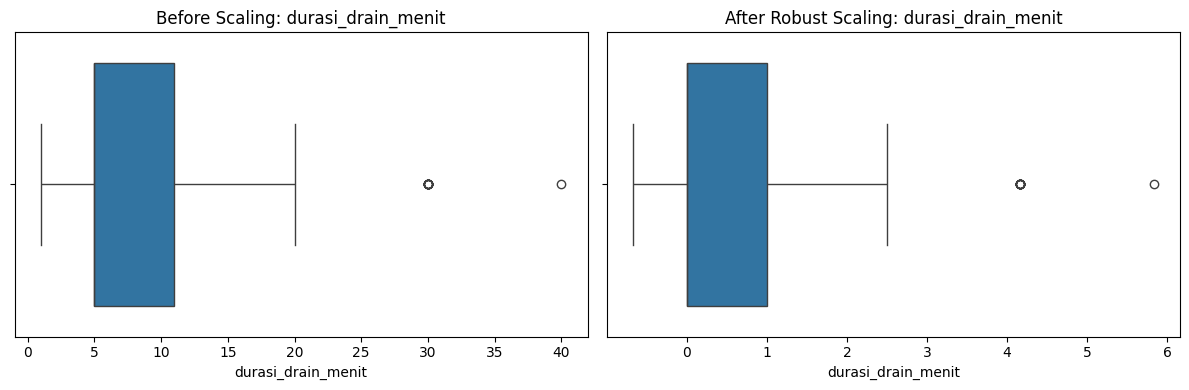

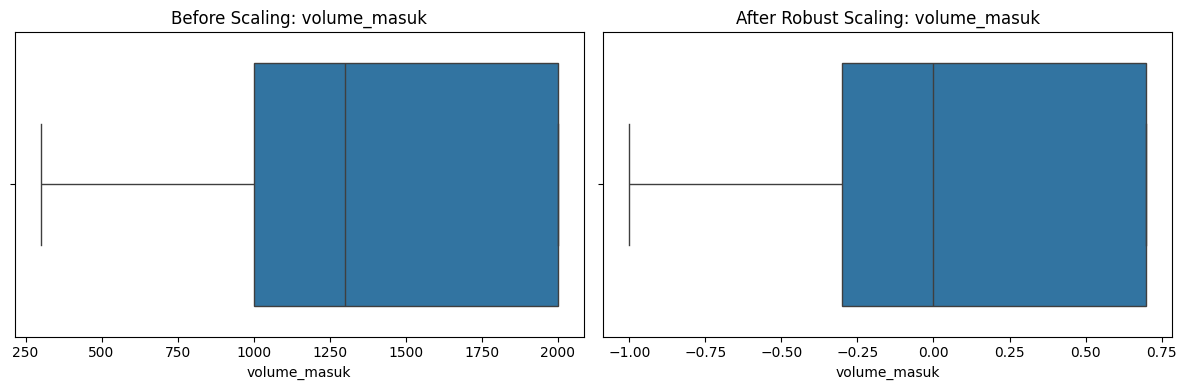

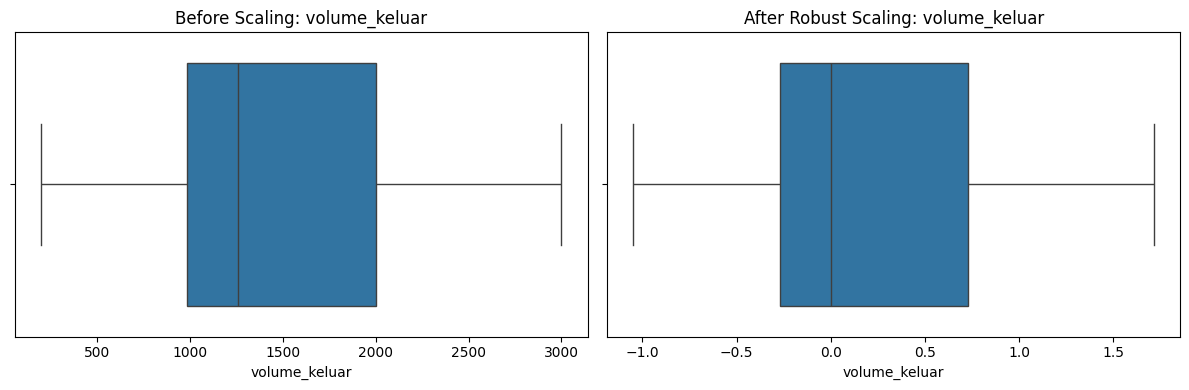

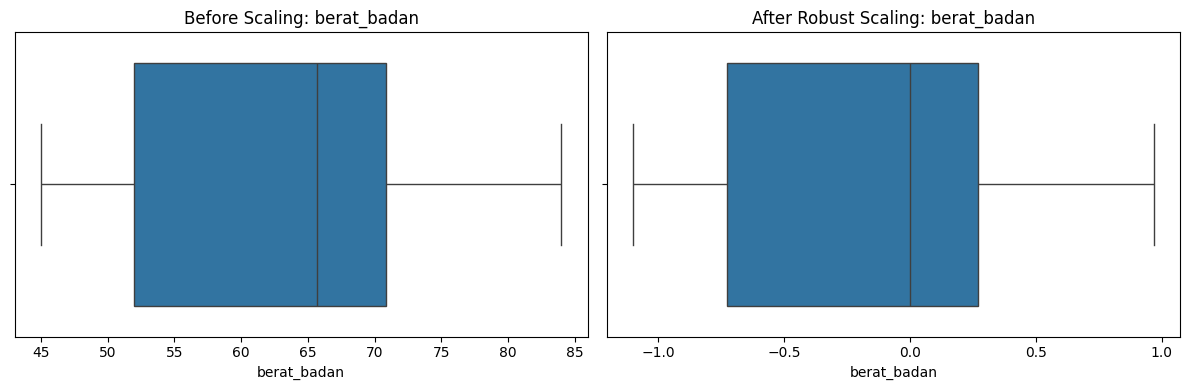

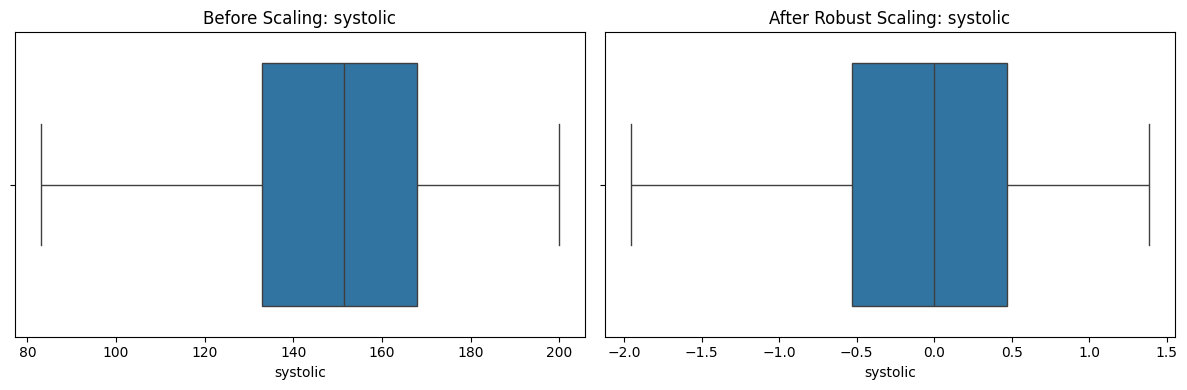

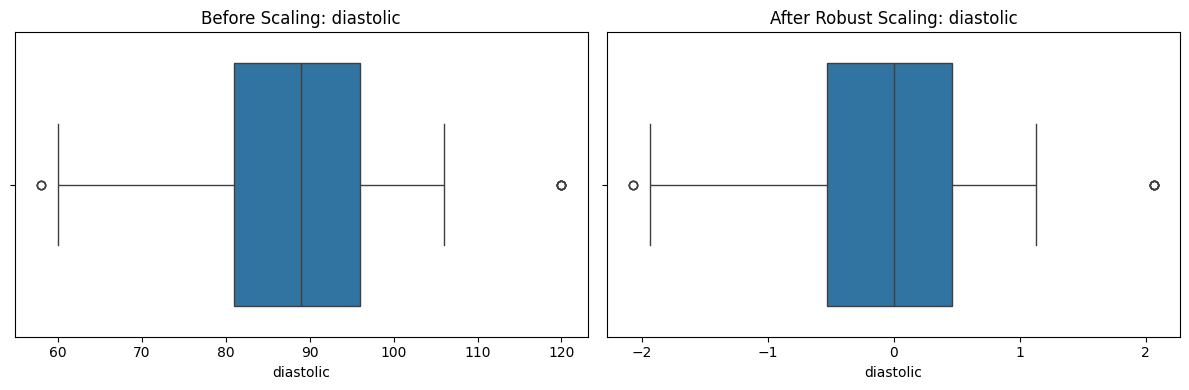

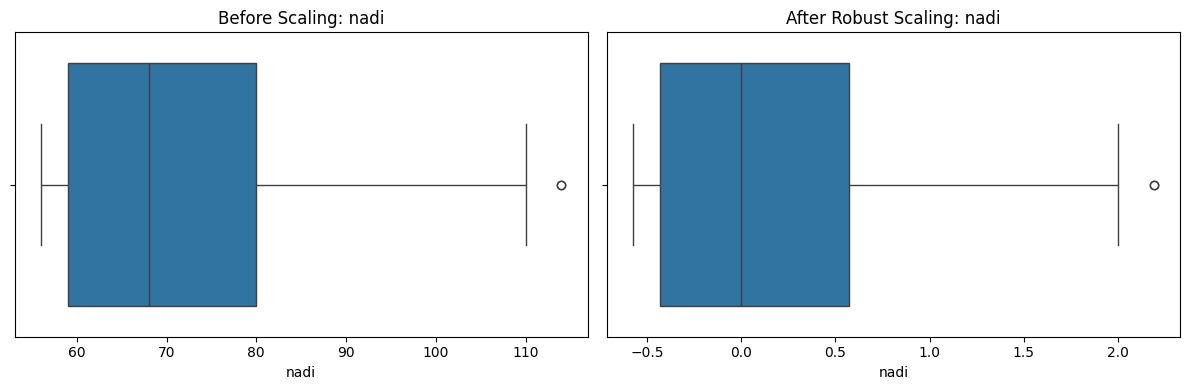

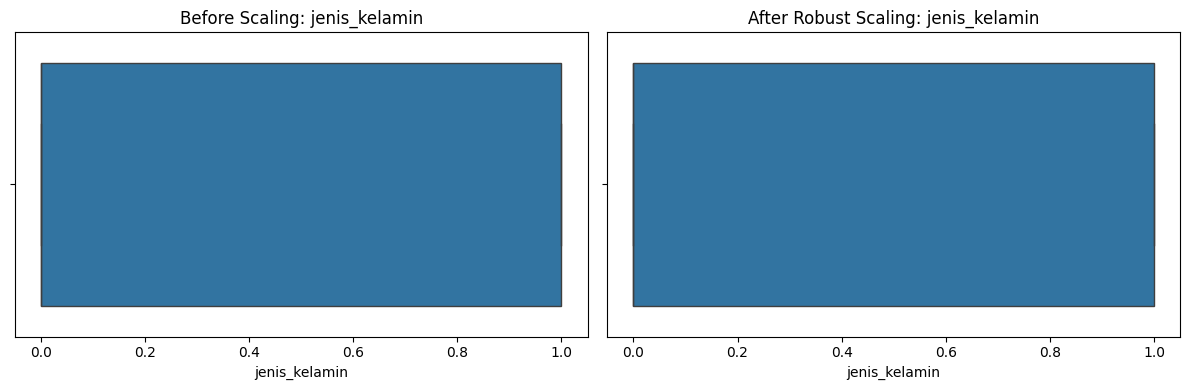

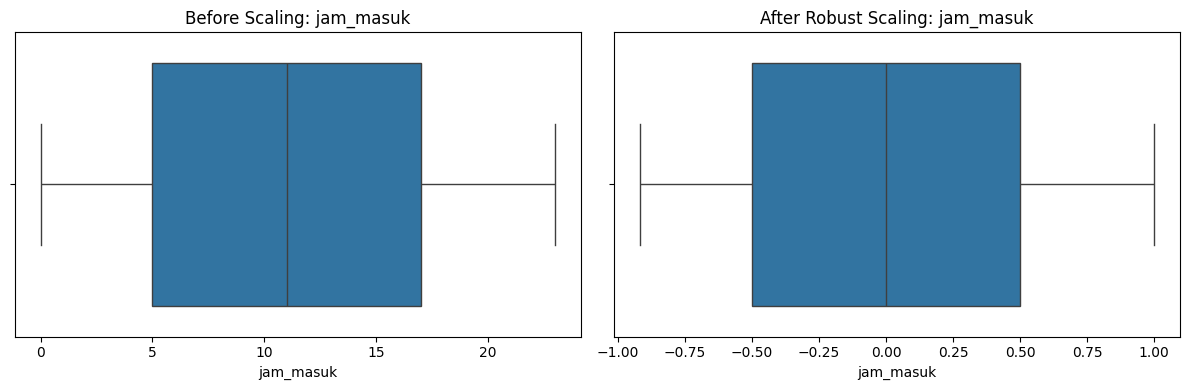

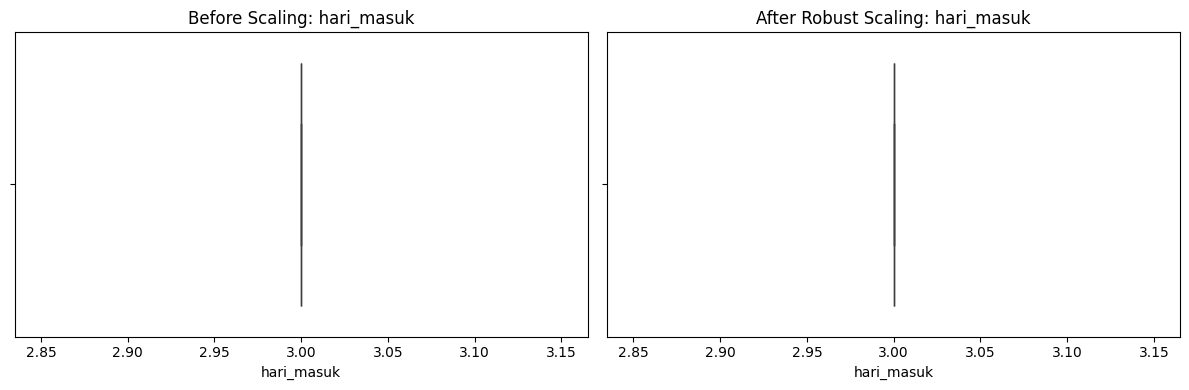

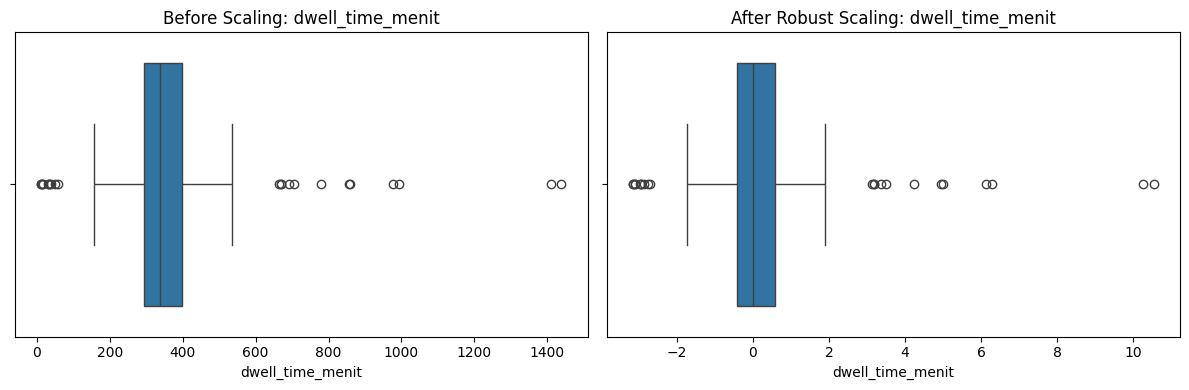

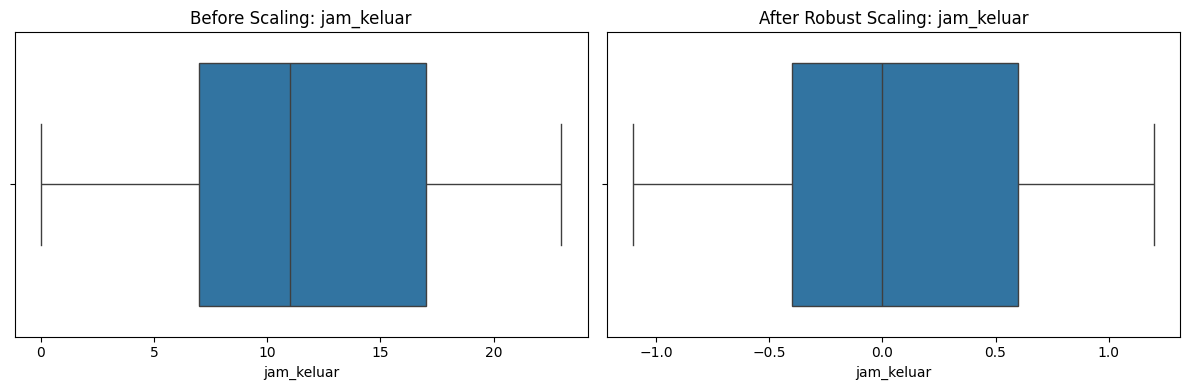

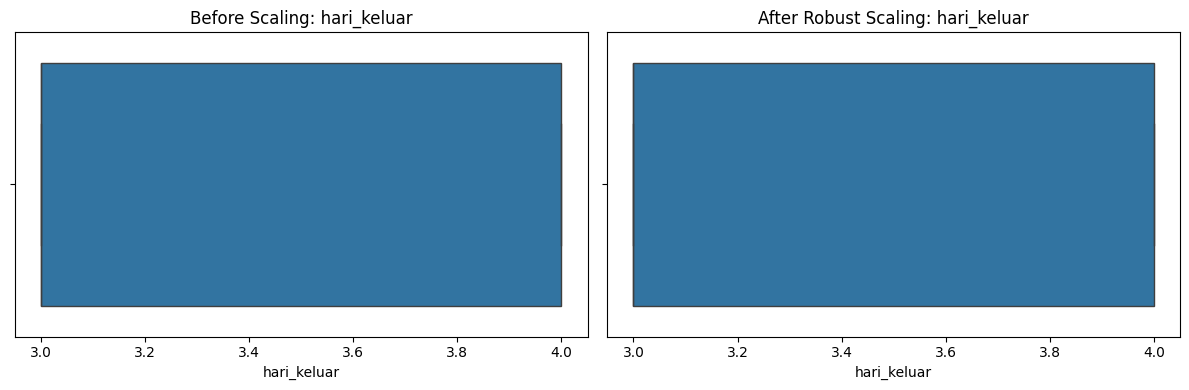

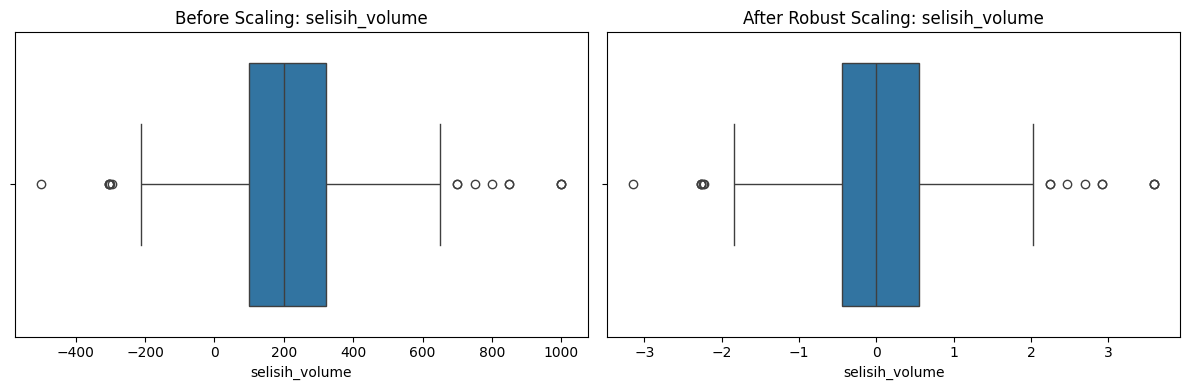

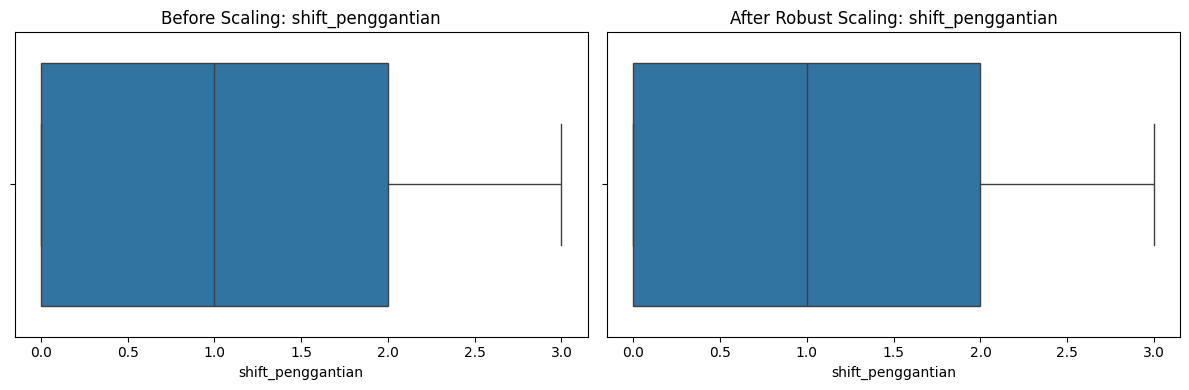

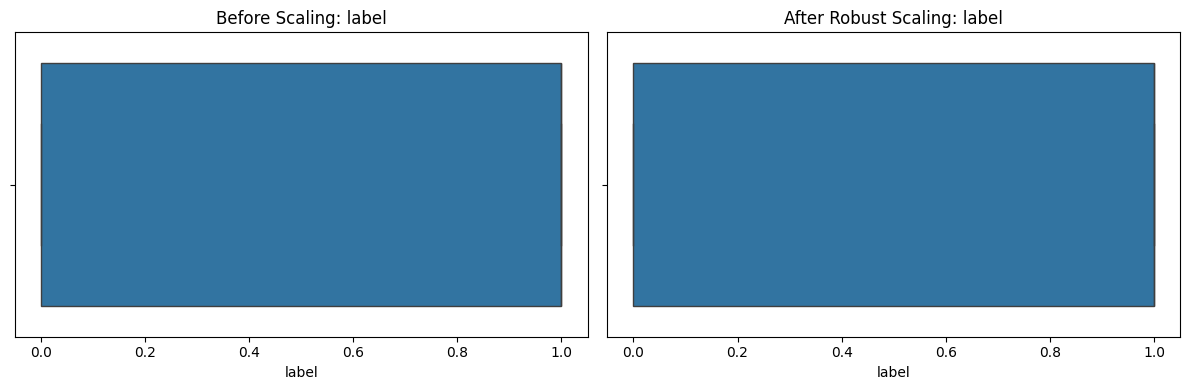

In [35]:
# Contoh model dan GAN
example_gan = gan_methods[0]
example_model = models[0]

# Ambil data sebelum dan sesudah scaling
original_df = combined_data[example_gan][example_model]
scaled_df = scaled_combined_data[example_gan][example_model]

# Pilih 2-3 fitur numerik untuk visualisasi
features_to_plot = original_df.iloc[:, -16:].columns.tolist()

# Plot sebelum dan sesudah scaling
for feature in features_to_plot:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_df[feature])
    plt.title(f"Before Scaling: {feature}")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=scaled_df[feature])
    plt.title(f"After Robust Scaling: {feature}")

    plt.tight_layout()
    plt.show()


## Modelling

### Early Modelling

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    "LogisticRegression": LogisticRegression(
        C=0.01,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        metric='minkowski'
    ),
    "SVM": SVC(
        C=0.5,
        kernel='rbf',
        probability=True,
        random_state=42,
        gamma='scale'
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=4,
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        min_samples_split=5,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        max_depth=3,
        n_estimators=100,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        reg_alpha=0.5,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    "NaiveBayes": GaussianNB(),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    "NeuralNetwork": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    
}


In [31]:
from sklearn.metrics import recall_score, f1_score, precision_score

results = []

for gan in gan_methods:
    for model_name in models:  # Gunakan models, bukan split_real_data.items()

        # Ambil data train yang sudah discaling dan sudah ter-scaling
        X_train = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_train = scaled_combined_data[gan][model_name]['label'].values

        X_test_feat = split_real_data[model_name]["X_test"].iloc[:, :-16]
        X_test_tabular = split_real_data[model_name]["X_test"].iloc[:, -16:]

        # Terapkan PCA pada fitur
        pca = pca_results[model_name]['pca']
        X_test_pca = pca.transform(X_test_feat)
        X_test_pca = pd.DataFrame(X_test_pca)

        # Gabungkan hasil PCA dengan data tabular
        X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

        # Pisahkan data kategorikal dan numerikal
        num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()

        X_test_num = X_test_pca[num_data]
        X_test_cat = X_test_pca[categorical_columns]

        X_test_num.columns = X_test_num.columns.astype(str)

        # Scaling data test menggunakan scaler dari data train
        scaler = scalers[gan][model_name]
        X_test_scaled = scaler.transform(X_test_num)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
        
        # X_test_scaled = pd.DataFrame(X_test_num, columns=X_test_num.columns, index=X_test_pca.index)

        # Gabungkan kembali data test yang sudah discaling dengan data kategorikal
        X_test_scaled[categorical_columns] = X_test_cat

        # Siapkan data train dan test final
        X_test_final = pd.DataFrame(X_test_scaled)
        X_train_final = pd.DataFrame(X_train, columns=X_test_final.columns)

        y_train_final = y_train.ravel()
        y_test_final = y_test.ravel()

        for clf_name, clf in classifiers.items():
            clf.fit(X_train_final, y_train_final)

            # Train metrics
            y_train_pred = clf.predict(X_train_final)
            recall_train = recall_score(y_train_final, y_train_pred)
            f1_train = f1_score(y_train_final, y_train_pred)
            precision_train = precision_score(y_train_final, y_train_pred)

            # Test metrics
            y_test_pred = clf.predict(X_test_final)
            recall_test = recall_score(y_test_final, y_test_pred)
            f1_test = f1_score(y_test_final, y_test_pred)
            precision_test = precision_score(y_test_final, y_test_pred)

            results.append({
                'GAN':gan,
                "Pretrained_Model": model_name,
                "Classifier": clf_name,
                "Recall_Train": recall_train,
                "F1_Train": f1_train,
                "Precision_Train": precision_train,
                "Recall_Test": recall_test,
                "F1_Test": f1_test,
                "Precision_Test": precision_test
            })

results_df = pd.DataFrame(results)

In [32]:
results_df.sort_values(by=["GAN", "Pretrained_Model", "Classifier"], inplace=True)
results_df.reset_index(drop=True, inplace=True)

results_df.head()

,GAN,Pretrained_Model,Classifier,Recall_Train,F1_Train,Precision_Train,Recall_Test,F1_Test,Precision_Test
0,copulagan,cait,AdaBoost,1.000000,1.000000,1.000000,0.870968,0.900000,0.931034
1,copulagan,cait,DecisionTree,0.996094,0.992218,0.988372,0.870968,0.843750,0.818182
2,copulagan,cait,ExtraTrees,1.000000,1.000000,1.000000,0.903226,0.949153,1.000000
3,copulagan,cait,KNN,0.980469,0.974757,0.969112,0.935484,0.920635,0.906250
4,copulagan,cait,LogisticRegression,0.953125,0.970179,0.987854,0.870968,0.931034,1.000000


In [33]:
results_df.to_csv('early_modelling.csv')

### cross validation

In [34]:
# CV REVISI
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_score

results = []

for gan in gan_methods:
    for model_name in models:

        # Ambil data gabungan dan label
        X_all = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_all = scaled_combined_data[gan][model_name]['label'].values

        for clf_name, clf in classifiers.items():
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            X_test_feat = split_real_data[model_name]["X_test"].iloc[:, :-16]
            X_test_tabular = split_real_data[model_name]["X_test"].iloc[:, -16:]

            # Terapkan PCA pada fitur
            pca = pca_results[model_name]['pca']
            X_test_pca = pca.transform(X_test_feat)
            X_test_pca = pd.DataFrame(X_test_pca)

            # Gabungkan hasil PCA dengan data tabular
            X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

            # Pisahkan data kategorikal dan numerikal
            num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()

            X_test_num = X_test_pca[num_data]
            X_test_cat = X_test_pca[categorical_columns]

            X_test_num.columns = X_test_num.columns.astype(str)

            # Scaling data test menggunakan scaler dari data train
            scaler = scalers[gan][model_name]
            X_test_scaled = scaler.transform(X_test_num)
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
            # X_test_scaled = X_test_num

            # Gabungkan kembali data test yang sudah discaling dengan data kategorikal
            X_test_scaled[categorical_columns] = X_test_cat

            # Siapkan data train dan test final
            X_test_final = pd.DataFrame(X_test_scaled)
            y_test_final = y_test.ravel()

            recalls, recalls_test = [], []
            f1s, f1s_test = [], []
            precisions, precisions_test = [], []
            # best_fold_model = None  # Placeholder for the best model
            # best_avg_score = -1  # Nilai untuk menyimpan skor rata-rata terbaik

            # Melakukan cross-validation untuk memilih model terbaik
            for train_idx, test_idx in skf.split(X_all, y_all):
                X_train_cv, X_test_cv = X_all[train_idx], X_all[test_idx]
                y_train_cv, y_test_cv = y_all[train_idx], y_all[test_idx]

                clf.fit(X_train_cv, y_train_cv)
                y_pred_cv = clf.predict(X_test_cv)

                # Hitung metrik evaluasi untuk setiap fold
                recall = recall_score(y_test_cv, y_pred_cv)
                f1 = f1_score(y_test_cv, y_pred_cv)
                precision = precision_score(y_test_cv, y_pred_cv)

                recalls.append(recall)
                f1s.append(f1)
                precisions.append(precision)

                y_pred_test = clf.predict(X_test_final) 

                # Evaluasi model terbaik dengan menggunakan y_test
                recall_test = recall_score(y_test_final, y_pred_test)
                f1_test = f1_score(y_test_final, y_pred_test)
                precision_test = precision_score(y_test_final, y_pred_test)

                recalls_test.append(recall)
                f1s_test.append(f1)
                precisions_test.append(precision)
            

            # Menambahkan hasil cross-validation ke dalam DataFrame
            results.append({
                'GAN': gan,
                'Pretrained_Model': model_name,
                'Classifier': clf_name,
                'Precision_CV_Mean': round(np.mean(precisions), 4),
                'Precision_CV_Std': round(np.std(precisions), 4),
                'Recall_CV_Mean': round(np.mean(recalls), 4),
                'Recall_CV_Std': round(np.std(recalls), 4),
                'F1_CV_Mean': round(np.mean(f1s), 4),
                'F1_CV_Std': round(np.std(f1s), 4),
                'Recall_Test': round(np.mean(recalls_test), 4),
                'F1_Test': round(np.mean(f1s_test), 4),
                'Precision_Test': round(np.mean(precisions_test), 4)
            })

# Menyimpan hasil cross-validation ke dalam DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by=["GAN", "Pretrained_Model", "Classifier"], inplace=True)
results_df.reset_index(drop=True, inplace=True)


In [35]:
results_df.head()

,GAN,Pretrained_Model,Classifier,Precision_CV_Mean,Precision_CV_Std,Recall_CV_Mean,Recall_CV_Std,F1_CV_Mean,F1_CV_Std,Recall_Test,F1_Test,Precision_Test
0,copulagan,cait,AdaBoost,0.9762,0.0081,0.9650,0.0255,0.9705,0.0164,0.9650,0.9705,0.9762
1,copulagan,cait,DecisionTree,0.9175,0.0168,0.9493,0.0361,0.9327,0.0185,0.9493,0.9327,0.9175
2,copulagan,cait,ExtraTrees,0.9841,0.0147,0.9492,0.0199,0.9662,0.0134,0.9492,0.9662,0.9841
3,copulagan,cait,KNN,0.9649,0.0145,0.9649,0.0146,0.9649,0.0133,0.9649,0.9649,0.9649
4,copulagan,cait,LogisticRegression,0.9797,0.0124,0.9298,0.0195,0.9539,0.0081,0.9298,0.9539,0.9797


In [36]:
results_df.to_csv('cv_revisi.csv')

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_score

results = []

for gan in gan_methods:
    for model_name in models:

        # Ambil data gabungan dan label
        X_all = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_all = scaled_combined_data[gan][model_name]['label'].values

        for clf_name, clf in classifiers.items():
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            recalls = []
            f1s = []
            precisions = []

            for train_idx, test_idx in skf.split(X_all, y_all):
                X_train_cv, X_test_cv = X_all[train_idx], X_all[test_idx]
                y_train_cv, y_test_cv = y_all[train_idx], y_all[test_idx]

                clf.fit(X_train_cv, y_train_cv)
                y_pred_cv = clf.predict(X_test_cv)

                recalls.append(recall_score(y_test_cv, y_pred_cv))
                f1s.append(f1_score(y_test_cv, y_pred_cv))
                precisions.append(precision_score(y_test_cv, y_pred_cv))


            results.append({
                'GAN': gan,
                'Pretrained_Model': model_name,
                'Classifier': clf_name,
                'Precision_CV_Mean': round(np.mean(precisions), 4),
                'Precision_CV_Std': round(np.std(precisions), 4),
                'Recall_CV_Mean': round(np.mean(recalls), 4),
                'Recall_CV_Std': round(np.std(recalls), 4),
                'F1_CV_Mean': round(np.mean(f1s), 4),
                'F1_CV_Std': round(np.std(f1s), 4)
            })


In [34]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=["GAN", "Pretrained_Model", "Classifier"], inplace=True)
results_df.reset_index(drop=True, inplace=True)

In [35]:
results_df.to_csv('cv.csv')

In [ ]:
temp = split_real_data['swin']['X_train'].copy()

In [ ]:
temp = temp.drop(columns=categorical_columns)

In [ ]:
final_test_results = []

for gan in gan_methods:
    for model_name in models:

        # Ambil data train dan test
        X_train = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_train = scaled_combined_data[gan][model_name]['label'].values

        X_test_feat = split_real_data[model_name]["X_test"].iloc[:, :-16]
        X_test_tabular = split_real_data[model_name]["X_test"].iloc[:, -16:]

        # PCA
        pca = pca_results[model_name]['pca']
        X_test_pca = pca.transform(X_test_feat)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

        # Pisah num / cat
        num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
        X_test_num = X_test_pca[num_data]
        X_test_cat = X_test_pca[categorical_columns]
        X_test_num.columns = X_test_num.columns.astype(str)

        # Scaling test pakai scaler dari train
        scaler = scalers[gan][model_name]
        X_test_scaled = scaler.transform(X_test_num)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
        X_test_scaled[categorical_columns] = X_test_cat

        # Finalize train-test sets
        X_test_final = pd.DataFrame(X_test_scaled)
        X_train_final = pd.DataFrame(X_train, columns=X_test_final.columns)

        y_train_final = y_train.ravel()
        y_test_final = split_real_data[model_name]["y_test"].ravel()

        for clf_name, clf in classifiers.items():
            # Retrain model di full training data
            clf.fit(X_train_final, y_train_final)

            # Prediksi test
            y_test_pred = clf.predict(X_test_final)

            recall_test = recall_score(y_test_final, y_test_pred)
            f1_test = f1_score(y_test_final, y_test_pred)
            precision_test = precision_score(y_test_final, y_test_pred)

            final_test_results.append({
                'GAN': gan,
                "Pretrained_Model": model_name,
                "Classifier": clf_name,
                "Recall_Test_Final": recall_test,
                "F1_Test_Final": f1_test,
                "Precision_Test_Final": precision_test
            })

# Jadiin DataFrame
final_test_results_df = pd.DataFrame(final_test_results)
final_test_results_df.sort_values(by=["GAN", "Pretrained_Model", "Classifier"], inplace=True)
final_test_results_df.reset_index(drop=True, inplace=True)


In [ ]:
final_test_results_df = pd.DataFrame(final_test_results)
final_test_results_df.sort_values(by=["Recall_Test_Final", "F1_Test_Final", "Precision_Test_Final"], inplace=True, ascending=False)
final_test_results_df.reset_index(drop=True, inplace=True)
final_test_results_df

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

for gan in gan_methods:
    for model_name in models:
        # Ambil data train dan test
        X_train = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_train = scaled_combined_data[gan][model_name]['label'].values

        X_test_feat = split_real_data[model_name]["X_test"].iloc[:, :-16]
        X_test_tabular = split_real_data[model_name]["X_test"].iloc[:, -16:]

        # PCA
        pca = pca_results[model_name]['pca']
        X_test_pca = pca.transform(X_test_feat)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

        # Pisah num / cat
        num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
        X_test_num = X_test_pca[num_data]
        X_test_cat = X_test_pca[categorical_columns]
        X_test_num.columns = X_test_num.columns.astype(str)

        # Scaling test pakai scaler dari train
        scaler = scalers[gan][model_name]
        X_test_scaled = scaler.transform(X_test_num)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
        X_test_scaled[categorical_columns] = X_test_cat

        # Finalize train-test sets
        X_test_final = pd.DataFrame(X_test_scaled)
        X_train_final = pd.DataFrame(X_train, columns=X_test_final.columns)

        y_train_final = y_train.ravel()
        y_test_final = split_real_data[model_name]["y_test"].ravel()

        for clf_name, clf in classifiers.items():
            clf.fit(X_train_final, y_train_final)

            # Prediksi ke data test real
            y_pred = clf.predict(X_test_final)

            # Confusion Matrix
            cm = confusion_matrix(y_test_final, y_pred)
            labels = ['Normal (0)', 'Abnormal (1)']

            print(f"\n=== Confusion Matrix: {gan} | {model_name} | {clf_name} ===")
            print(classification_report(y_test_final, y_pred, target_names=labels))

            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix: {gan} | {model_name} | {clf_name}")
            plt.show()


### Hyperparameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

param_grids = {
    "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 0.5, 1, 10],
        "penalty": ['l1', 'l2'],
        "solver": ['liblinear']
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    "SVM": {
        "C": [0.1, 0.5, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    },
    "DecisionTree": {
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 4, 5],
        "criterion": ['gini', 'entropy']
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 4, 5, 10],
        "min_samples_split": [2, 5],
        "criterion": ['gini', 'entropy']
    },
    "AdaBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_lambda": [0, 1],
        "reg_alpha": [0, 0.5]
    },
    "NaiveBayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "ExtraTrees": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "criterion": ['gini', 'entropy']
    },
    "NeuralNetwork": {
        "hidden_layer_sizes": (64,32),
        "activation": ['relu'],
        "solver": ['adam'],
        "learning_rate_init": [0.0005, 0.001, 0.005, 0.01],
        "early_stopping": [True],
        "max_iter": [500],
        "random_state": [42]
    }
}


In [37]:
import os
import multiprocessing

print("Total CPU (os):", os.cpu_count())
print("Total CPU (multiprocessing):", multiprocessing.cpu_count())


Total CPU (os): 32
Total CPU (multiprocessing): 32


In [30]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import recall_score, f1_score, precision_score

# Untuk loop final kamu:
best_models = []
final_test_results = []

total_iterations = len(gan_methods) * len(models) * len(classifiers)
pbar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for gan in gan_methods:
    for model_name in models:

        # === PREPROCESSING SAMA SEPERTI SEBELUMNYA ===
        X_train = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
        y_train = scaled_combined_data[gan][model_name]['label'].values

        X_test_feat = split_real_data[model_name]["X_test"].iloc[:, :-16]
        X_test_tabular = split_real_data[model_name]["X_test"].iloc[:, -16:]

        # PCA
        pca = pca_results[model_name]['pca']
        X_test_pca = pca.transform(X_test_feat)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

        # Pisah num / cat
        num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
        X_test_num = X_test_pca[num_data]
        X_test_cat = X_test_pca[categorical_columns]
        X_test_num.columns = X_test_num.columns.astype(str)

        # Scaling test pakai scaler dari train
        scaler = scalers[gan][model_name]
        X_test_scaled = scaler.transform(X_test_num)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)


        # X_test_scaled = X_test_num
        X_test_scaled[categorical_columns] = X_test_cat

        # Finalize train-test sets
        X_test_final = pd.DataFrame(X_test_scaled)
        X_train_final = pd.DataFrame(X_train, columns=X_test_final.columns)

        y_train_final = y_train.ravel()
        y_test_final = split_real_data[model_name]["y_test"].to_numpy()

        for clf_name, clf in classifiers.items():
            param_grid = param_grids.get(clf_name)
            if param_grid is None:
                pbar.update(1)
                continue  # skip if classifier tidak ada gridnya

            grid_search = GridSearchCV(
                estimator=clf,
                param_grid=param_grid,
                scoring='f1',
                cv=5,
                n_jobs=32,
                verbose=0
            )
            grid_search.fit(X_train_final, y_train_final)

            best_model = grid_search.best_estimator_
            y_test_pred = best_model.predict(X_test_final)

            recall_test = recall_score(y_test_final, y_test_pred)
            f1_test = f1_score(y_test_final, y_test_pred)
            precision_test = precision_score(y_test_final, y_test_pred)

            final_test_results.append({
                'GAN': gan,
                "Pretrained_Model": model_name,
                "Classifier": clf_name,
                "Precision_Test_Final": precision_test,
                "Recall_Test_Final": recall_test,
                "F1_Test_Final": f1_test,
                "Best_Params": grid_search.best_params_
            })

            best_models.append({
                'GAN': gan,
                'Pretrained_Model': model_name,
                'Classifier': clf_name,
                'Model': best_model
            })

            pbar.update(1)

pbar.close()


Hyperparameter Tuning:  35%|███▌      | 56/160 [02:44<01:50,  1.06s/it]

KeyboardInterrupt: 

In [ ]:
final_test_results_df = pd.DataFrame(final_test_results)
final_test_results_df.sort_values(by=["GAN", "Pretrained_Model", "Classifier"], inplace=True)
final_test_results_df.reset_index(drop=True, inplace=True)
pd.set_option('display.max_colwidth', None)


In [ ]:
final_test_results_df.to_csv('tuning.csv')

### modelling tanpa synthetic data

In [19]:
categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian']

In [59]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import recall_score, f1_score, precision_score

final_test_results = []
for model_name, data in split_real_data.items():
    X_train = pca_results[model_name]['X_train']
    X_train = pd.DataFrame(X_train)
    y_train = pca_results[model_name]['y_train']
    y_train = pd.DataFrame(y_train)

    X_test_feat = data["X_test"].iloc[:, :-16]
    X_test_tabular = data["X_test"].iloc[:, -16:]

    # PCA
    pca = pca_results[model_name]['pca']
    X_test_pca = pca.transform(X_test_feat)
    X_test_pca = pd.DataFrame(X_test_pca)
    X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

    # Pisah num / cat
    num_data_train = X_train.drop(columns=categorical_columns).columns.tolist()
    X_train_num = X_train[num_data_train]
    X_train_cat = X_train[categorical_columns]

    X_train_num.columns = X_train_num.columns.astype(str)
    X_train.columns = X_train.columns.astype(str)

    num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
    X_test_num = X_test_pca[num_data]
    X_test_cat = X_test_pca[categorical_columns]
    X_test_num.columns = X_test_num.columns.astype(str)

    # Scaling with RobustScaler
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_num)
    # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns, index=X_train.index)
    # X_train_scaled[categorical_columns] = X_train_cat
    X_train_scaled = pd.DataFrame(X_train_num, columns=X_train_num.columns, index=X_train.index)
    X_train_scaled[categorical_columns] = X_train_cat

    # X_test_scaled = scaler.transform(X_test_num)
    # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
    # X_test_scaled[categorical_columns] = X_test_cat
    X_test_scaled = pd.DataFrame(X_test_num, columns=X_test_num.columns, index=X_test_pca.index)
    X_test_scaled[categorical_columns] = X_test_cat

    # Finalize train-test sets
    X_test_final = pd.DataFrame(X_test_scaled)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_test_final.columns)

    y_train_final = y_train.copy()
    y_test_final = data["y_test"].ravel()

    for clf_name, clf in classifiers.items():
        # Ensure fitting on correctly scaled data
        clf.fit(X_train_final, y_train_final)

        # Predict on test data
        y_pred = clf.predict(X_test_final)
        y_pred_train = clf.predict(X_train_final)

        recall_train = recall_score(y_train_final, y_pred_train)
        f1_train = f1_score(y_train_final, y_pred_train)
        precision_train = precision_score(y_train_final, y_pred_train)

        recall = recall_score(y_test_final, y_pred)
        f1 = f1_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred)

        final_test_results.append({
            "Pretrained_Model": model_name,
            "Classifier": clf_name,
            "Recall_Train_Final": recall_train,
            "F1_Train_Final": f1_train,
            "Precision_Train_Final": precision_train,
            "Recall_Test_Final": recall,
            "F1_Test_Final": f1,
            "Precision_Test_Final": precision
        })

# Convert to DataFrame
final_test_results_df = pd.DataFrame(final_test_results)
final_test_results_df.sort_values(by=["Pretrained_Model", "Classifier"], inplace=True)
final_test_results_df.reset_index(drop=True, inplace=True)
final_test_results_df.head()

,Pretrained_Model,Classifier,Recall_Train_Final,F1_Train_Final,Precision_Train_Final,Recall_Test_Final,F1_Test_Final,Precision_Test_Final
0,cait,AdaBoost,1.000000,1.000000,1.000000,0.838710,0.896552,0.962963
1,cait,DecisionTree,1.000000,0.983957,0.968421,0.838710,0.838710,0.838710
2,cait,ExtraTrees,1.000000,1.000000,1.000000,0.935484,0.966667,1.000000
3,cait,KNN,0.913043,0.879581,0.848485,0.935484,0.892308,0.852941
4,cait,LogisticRegression,0.934783,0.950276,0.966292,0.935484,0.950820,0.966667


In [60]:
final_test_results_df.to_csv('early_modelling.csv')

#### Cross Validation

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas as pd
import numpy as np

cv_results = []

for model_name, data in split_real_data.items():
    X = data["X_train"].copy()
    y = data["y_train"].copy().ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    X_test_feat = data["X_test"].iloc[:, :-16]
    X_test_tabular = data["X_test"].iloc[:, -16:]

    # Terapkan PCA pada fitur
    pca = pca_results[model_name]['pca']
    X_test_pca = pca.transform(X_test_feat)
    X_test_pca = pd.DataFrame(X_test_pca)

    # Gabungkan hasil PCA dengan data tabular
    X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

    # Pisahkan data kategorikal dan numerikal
    num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()

    X_test_num = X_test_pca[num_data]
    X_test_cat = X_test_pca[categorical_columns]

    X_test_num.columns = X_test_num.columns.astype(str)

    

    for clf_name, clf in classifiers.items():
        recalls, recalls_test = [], []
        f1s, f1s_test = [], []
        precisions, precisions_test = [], []
        # best_fold_model = None  # Placeholder for the best model
        # best_avg_score = -1
        # best_scaler = StandardScaler()

        for train_idx, test_idx in skf.split(X, y):
            X_train_raw, X_val_raw = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y[train_idx], y[test_idx]

            # Pisahkan fitur gambar dan tabular
            X_train_feat = X_train_raw.iloc[:, :-16]
            X_train_tabular = X_train_raw.iloc[:, -16:]
            X_val_feat = X_val_raw.iloc[:, :-16]
            X_val_tabular = X_val_raw.iloc[:, -16:]

            # PCA dari pca_results
            pca = pca_results[model_name]['pca']
            X_train_pca = pca.transform(X_train_feat)
            X_val_pca = pca.transform(X_val_feat)

            X_train_pca = pd.DataFrame(X_train_pca)
            X_train_pca = pd.concat([X_train_pca, X_train_tabular.reset_index(drop=True)], axis=1)

            X_val_pca = pd.DataFrame(X_val_pca)
            X_val_pca = pd.concat([X_val_pca, X_val_tabular.reset_index(drop=True)], axis=1)

            # Pisahkan numerik dan kategorikal
            num_data_train = X_train_pca.drop(columns=categorical_columns).columns.tolist()
            X_train_num = X_train_pca[num_data_train]
            X_train_cat = X_train_pca[categorical_columns]
            X_train_num.columns = X_train_num.columns.astype(str)

            num_data_val = X_val_pca.drop(columns=categorical_columns).columns.tolist()
            X_val_num = X_val_pca[num_data_val]
            X_val_cat = X_val_pca[categorical_columns]
            X_val_num.columns = X_val_num.columns.astype(str)
            

            # Scaling
            # scaler = StandardScaler()
            # X_train_scaled = scaler.fit_transform(X_train_num)
            # X_val_scaled = scaler.transform(X_val_num)
            X_train_scaled = X_train_num
            X_val_scaled = X_val_num

            X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)
            X_train_final[categorical_columns] = X_train_cat.reset_index(drop=True)

            X_val_final = pd.DataFrame(X_val_scaled, columns=X_val_num.columns)
            X_val_final[categorical_columns] = X_val_cat.reset_index(drop=True)

            # Fit & predict
            clf.fit(X_train_final, y_train)
            y_pred = clf.predict(X_val_final)

            # Metrics
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)

            recalls.append(recall)
            f1s.append(f1)
            precisions.append(precision)

            # Scaling data test menggunakan scaler dari data train
            # X_test_scaled = scaler.transform(X_test_num)
            # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
            X_test_scaled = X_test_num

            # Gabungkan kembali data test yang sudah discaling dengan data kategorikal
            X_test_scaled[categorical_columns] = X_test_cat

            # Siapkan data train dan test final
            X_test_final = pd.DataFrame(X_test_scaled)
            y_test_final = y_test.ravel()

            y_pred_test = clf.predict(X_test_final)

            recall_test = recall_score(y_test_final, y_pred_test)
            f1_test = f1_score(y_test_final, y_pred_test)
            precision_test = precision_score(y_test_final, y_pred_test)

            recalls_test.append(recall_test)
            f1s_test.append(f1_test)
            precisions_test.append(precision_test)

            # Pilih model terbaik berdasarkan rata-rata score
            # if avg_score > best_avg_score:
            #     best_avg_score = avg_score
            #     best_fold_model = clf
            #     best_scaler = scaler


        # Rata-rata hasil per classifier
        cv_results.append({
            "Pretrained_Model": model_name,
            "Classifier": clf_name,
            "Precision_CV_Mean": round(np.mean(precisions), 4),
            "Precision_CV_Std": round(np.std(precisions), 4),
            "Recall_CV_Mean": round(np.mean(recalls), 4),
            "Recall_CV_Std": round(np.std(recalls), 4),
            "F1_CV_Mean": round(np.mean(f1s), 4),
            "F1_CV_Std": round(np.std(f1s), 4),
            'Recall_Test': round(np.mean(recalls_test), 4),
            'F1_Test': round(np.mean(f1s_test), 4),
            'Precision_Test': round(np.mean(precisions_test), 4)
        })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.sort_values(by=["Pretrained_Model", "Classifier"], inplace=True)
cv_results_df.reset_index(drop=True, inplace=True)
cv_results_df.head()

,Pretrained_Model,Classifier,Precision_CV_Mean,Precision_CV_Std,Recall_CV_Mean,Recall_CV_Std,F1_CV_Mean,F1_CV_Std,Recall_Test,F1_Test,Precision_Test
0,cait,AdaBoost,0.9141,0.0226,0.9129,0.0543,0.9122,0.0227,0.8839,0.9131,0.9462
1,cait,DecisionTree,0.8540,0.0496,0.8708,0.0520,0.8605,0.0340,0.8000,0.8326,0.8703
2,cait,ExtraTrees,0.9764,0.0290,0.8509,0.1250,0.9037,0.0772,0.9161,0.9529,0.9931
3,cait,KNN,0.7703,0.0714,0.8497,0.0956,0.8043,0.0669,0.8839,0.8497,0.8204
4,cait,LogisticRegression,0.9161,0.0669,0.8924,0.0458,0.9025,0.0425,0.9290,0.9473,0.9664


In [62]:
cv_results_df.to_csv('cv_revisi.csv')

#### Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

param_grids = {
    "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 0.5, 1, 1.5, 10],
        "penalty": ['l1', 'l2'],
        "solver": ['liblinear']
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan']
    },
    "SVM": {
        "C": [0.1, 0.5, 1, 5, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    },
    "DecisionTree": {
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 4, 5, 10],
        "criterion": ['gini', 'entropy']
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 4, 5, 10],
        "min_samples_split": [2, 5],
        "criterion": ['gini', 'entropy']
    },
    "AdaBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_lambda": [0, 1],
        "reg_alpha": [0, 0.5]
    },
    "NaiveBayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "ExtraTrees": {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "criterion": ['gini', 'entropy']
    }
}




In [18]:
split_real_data.keys()

dict_keys(['swin', 'cait', 'coatnet', 'yolov9'])

In [50]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import recall_score, f1_score, precision_score

# Untuk loop final kamu:
best_models = []
final_test_results = []


total_iterations = len(split_real_data.keys()) * len(classifiers)
pbar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")


for model_name, data in split_real_data.items():

    # === PREPROCESSING SAMA SEPERTI SEBELUMNYA ===
    X_train = pca_results[model_name]['X_train']
    X_train = pd.DataFrame(X_train)
    y_train = pca_results[model_name]['y_train']
    y_train = pd.DataFrame(y_train)

    X_test_feat = data["X_test"].iloc[:, :-16]
    X_test_tabular = data["X_test"].iloc[:, -16:]

    # PCA
    pca = pca_results[model_name]['pca']
    X_test_pca = pca.transform(X_test_feat)
    X_test_pca = pd.DataFrame(X_test_pca)
    X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

    # Pisah num / cat
    num_data_train = X_train.drop(columns=categorical_columns).columns.tolist()
    X_train_num = X_train[num_data_train]
    X_train_cat = X_train[categorical_columns]

    X_train_num.columns = X_train_num.columns.astype(str)
    X_train.columns = X_train.columns.astype(str)

    num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
    X_test_num = X_test_pca[num_data]
    X_test_cat = X_test_pca[categorical_columns]
    X_test_num.columns = X_test_num.columns.astype(str)

    # Scaling with StandardScaler
    # scaler = RobustScaler()
    # X_train_scaled = scaler.fit_transform(X_train_num)
    # X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns, index=X_train.index)
    # X_train_scaled[categorical_columns] = X_train_cat
    X_train_scaled = pd.DataFrame(X_train_num, columns=X_train_num.columns, index=X_train.index)
    X_train_scaled[categorical_columns] = X_train_cat

    # X_test_scaled = scaler.transform(X_test_num)
    # X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
    # X_test_scaled[categorical_columns] = X_test_cat
    X_test_scaled = pd.DataFrame(X_test_num, columns=X_test_num.columns, index=X_test_pca.index)
    X_test_scaled[categorical_columns] = X_test_cat

    # Finalize train-test sets
    X_test_final = pd.DataFrame(X_test_scaled)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_test_final.columns)

    y_train_final = y_train.copy()
    y_test_final = data["y_test"].ravel()

    for clf_name, clf in classifiers.items():
        param_grid = param_grids.get(clf_name)
        if param_grid is None:
            pbar.update(1)
            continue  # skip if classifier tidak ada gridnya

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            scoring='f1',
            cv=3,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_final, y_train_final)

        best_model = grid_search.best_estimator_
        y_test_pred = best_model.predict(X_test_final)

        recall_test = recall_score(y_test_final, y_test_pred)
        f1_test = f1_score(y_test_final, y_test_pred)
        precision_test = precision_score(y_test_final, y_test_pred)

        final_test_results.append({
            "Pretrained_Model": model_name,
            "Classifier": clf_name,
            "Precision_Test_Final": precision_test,
            "Recall_Test_Final": recall_test,
            "F1_Test_Final": f1_test,
            "Best_Params": grid_search.best_params_
        })

        best_models.append({
            'Pretrained_Model': model_name,
            'Classifier': clf_name,
            'Model': best_model
        })

        pbar.update(1)

pbar.close()


Hyperparameter Tuning: 100%|██████████| 36/36 [01:20<00:00,  2.23s/it]


In [51]:
final_test_results = pd.DataFrame(final_test_results)
final_test_results.sort_values(by=["Pretrained_Model", "Classifier"], inplace=True)
final_test_results.reset_index(drop=True, inplace=True)
pd.set_option('display.max_colwidth', None)
final_test_results.head(9)

,Pretrained_Model,Classifier,Precision_Test_Final,Recall_Test_Final,F1_Test_Final,Best_Params
0,cait,AdaBoost,0.843750,0.870968,0.857143,"{'learning_rate': 1.0, 'n_estimators': 100}"
1,cait,DecisionTree,1.000000,0.774194,0.872727,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}"
2,cait,ExtraTrees,1.000000,0.870968,0.931034,"{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}"
3,cait,KNN,0.909091,0.967742,0.937500,"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}"
4,cait,LogisticRegression,0.967742,0.967742,0.967742,"{'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}"
5,cait,NaiveBayes,0.903226,0.903226,0.903226,{'var_smoothing': 1e-07}
6,cait,RandomForest,0.965517,0.903226,0.933333,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}"
7,cait,SVM,0.967742,0.967742,0.967742,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
8,cait,XGBoost,0.965517,0.903226,0.933333,"{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}"


In [52]:
final_test_results.to_csv('tuning.csv')

## Final Modelling

In [54]:
categorical_columns = ['jenis_kelamin', 'hari_masuk', 'hari_keluar', 'shift_penggantian']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import recall_score, f1_score, precision_score
import pandas as pd

results = []

# Tetapkan parameter tetap
gan = 'ctabgan'
model_name = 'cait'
clf_name = 'Logistic'

clf = LogisticRegression(C=0.5,
        penalty='l2',
        solver='liblinear',
        random_state=42)

# Ambil data train
X_train = scaled_combined_data[gan][model_name].drop(columns=["label"]).values
y_train = scaled_combined_data[gan][model_name]['label'].values

# Ambil data test
X_test_awal = split_real_data[model_name]["X_test"].copy()
original_indices_test = X_test_awal['original_index'].values  # <- disimpan sebagai numpy array

# Drop kolom original_index sebelum PCA
X_test_awal = X_test_awal.drop(columns=["original_index"])

X_test_feat = X_test_awal.iloc[:, :-16]
X_test_tabular = X_test_awal.iloc[:, -16:]

# PCA untuk fitur gambar
pca = pca_results[model_name]['pca']
X_test_pca = pca.transform(X_test_feat)
X_test_pca = pd.DataFrame(X_test_pca)

# Gabungkan dengan tabular
X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

# Pisahkan kolom numerik dan kategorikal
num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
X_test_num = X_test_pca[num_data]
X_test_cat = X_test_pca[categorical_columns]
X_test_num.columns = X_test_num.columns.astype(str)

# Scaling numerik test
scaler = scalers[gan][model_name]
X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)

# Gabungkan kembali dengan kolom kategorikal
X_test_scaled[categorical_columns] = X_test_cat

# Siapkan final train dan test
X_test_final = pd.DataFrame(X_test_scaled)
X_train_final = pd.DataFrame(X_train, columns=X_test_final.columns)

y_train_final = y_train.ravel()
y_test_final = y_test.ravel()

# Train model
clf.fit(X_train_final, y_train_final)

# Train metrics
y_train_pred = clf.predict(X_train_final)
recall_train = recall_score(y_train_final, y_train_pred)
f1_train = f1_score(y_train_final, y_train_pred)
precision_train = precision_score(y_train_final, y_train_pred)

# Test metrics
y_test_pred = clf.predict(X_test_final)
recall_test = recall_score(y_test_final, y_test_pred)
f1_test = f1_score(y_test_final, y_test_pred)
precision_test = precision_score(y_test_final, y_test_pred)

# Simpan hasil
results.append({
    'GAN': gan,
    "Pretrained_Model": model_name,
    "Classifier": clf_name,
    "Recall_Train": recall_train,
    "F1_Train": f1_train,
    "Precision_Train": precision_train,
    "Recall_Test": recall_test,
    "F1_Test": f1_test,
    "Precision_Test": precision_test
})

# Ubah ke DataFrame
results_df = pd.DataFrame(results)

NameError: name 'scaled_combined_data' is not defined

In [41]:
results_df

,GAN,Pretrained_Model,Classifier,Recall_Train,F1_Train,Precision_Train,Recall_Test,F1_Test,Precision_Test
0,ctabgan,cait,ExtraTrees,1.0,1.0,1.0,0.935484,0.966667,1.0


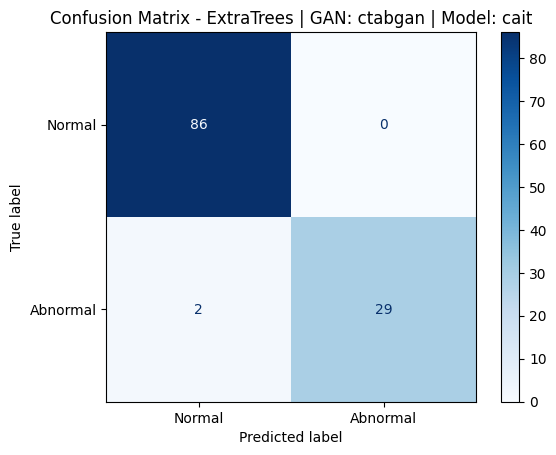

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(y_test_final, y_test_pred)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title(f'Confusion Matrix - {clf_name} | GAN: {gan} | Model: {model_name}')
plt.show()


In [43]:
# Temukan indeks False Negative
false_negative_idx = np.where((y_test_final == 1) & (y_test_pred == 0))[0]

# Ambil original index dari data test sebelum PCA (sudah disimpan sebelumnya)
original_indices = split_real_data["cait"]["X_test"]["original_index"].values

# Ambil original index dari FN
false_negative_original_idx = original_indices[false_negative_idx]

# Ambil data FN dari test set final
false_negative_samples = X_test_final.iloc[false_negative_idx]
false_negative_labels = y_test_final[false_negative_idx]
false_negative_preds = y_test_pred[false_negative_idx]

# Buat report FN
fn_report = false_negative_samples.copy()
fn_report["True_Label"] = false_negative_labels
fn_report["Predicted_Label"] = false_negative_preds
fn_report["Original_Index"] = false_negative_original_idx

# Tampilkan hasil
print(f"\nFalse Negatives (Total: {len(fn_report)}):")
print(fn_report[["Original_Index", "True_Label", "Predicted_Label"]])


False Negatives (Total: 2):
    Original_Index  True_Label  Predicted_Label
6              386           1                0
54             377           1                0


In [35]:
pd.DataFrame(fn_report)

,0,1,2,3,4,5,6,7,8,9,...,jam_masuk,dwell_time_menit,jam_keluar,selisih_volume,jenis_kelamin,hari_masuk,hari_keluar,shift_penggantian,True_Label,Predicted_Label
6,-0.036546,0.368366,-0.199048,-0.205108,-0.089161,-1.060380,-0.121557,-0.405433,-1.138158,-0.529099,...,1.373823,0.782332,-1.362459,0.350461,0.0,3.0,4.0,0.0,1,0
54,0.139277,-1.062745,-0.608079,-0.355525,0.496094,-0.825797,1.009297,0.430346,-1.569568,0.568573,...,-1.341381,-0.334800,-0.580420,-0.948356,0.0,3.0,3.0,1.0,1,0


In [27]:
split_real_data['cait']["X_test"].shape

(117, 399)

In [ ]:
df_2rows = fused_cait.loc[[386, 377]].copy()

In [54]:
df_2rows.to_csv('false_neg.csv')

In [62]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import recall_score, f1_score, precision_score

final_test_results = []
model_name = 'cait'
clf_name = 'Logistic Regression'
normalisasi_method = 'Standard Scaler'

clf = LogisticRegression(C=0.1,
        penalty='l2',
        solver='liblinear',
        random_state=42)

X_train = pca_results[model_name]['X_train']
X_train = pd.DataFrame(X_train)
y_train = pca_results[model_name]['y_train']
y_train = pd.DataFrame(y_train)

X_test_feat = split_real_data['cait']["X_test"].iloc[:, :-16]
X_test_tabular = split_real_data['cait']["X_test"].iloc[:, -16:]

# PCA
pca = pca_results[model_name]['pca']
X_test_pca = pca.transform(X_test_feat)
X_test_pca = pd.DataFrame(X_test_pca)
X_test_pca = pd.concat([X_test_pca, X_test_tabular.reset_index(drop=True)], axis=1)

# Pisah num / cat
num_data_train = X_train.drop(columns=categorical_columns).columns.tolist()
X_train_num = X_train[num_data_train]
X_train_cat = X_train[categorical_columns]

X_train_num.columns = X_train_num.columns.astype(str)
X_train.columns = X_train.columns.astype(str)

num_data = X_test_pca.drop(columns=categorical_columns).columns.tolist()
X_test_num = X_test_pca[num_data]
X_test_cat = X_test_pca[categorical_columns]
X_test_num.columns = X_test_num.columns.astype(str)

# Scaling with RobustScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns, index=X_train.index)
X_train_scaled[categorical_columns] = X_train_cat
# X_train_scaled = pd.DataFrame(X_train_num, columns=X_train_num.columns, index=X_train.index)
# X_train_scaled[categorical_columns] = X_train_cat

X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_num.columns, index=X_test_pca.index)
X_test_scaled[categorical_columns] = X_test_cat
# X_test_scaled = pd.DataFrame(X_test_num, columns=X_test_num.columns, index=X_test_pca.index)
# X_test_scaled[categorical_columns] = X_test_cat

# Finalize train-test sets
X_test_final = pd.DataFrame(X_test_scaled)
X_train_final = pd.DataFrame(X_train_scaled, columns=X_test_final.columns)

y_train_final = y_train.copy()
y_test_final = data["y_test"].ravel()

# Ensure fitting on correctly scaled data
clf.fit(X_train_final, y_train_final)

# Predict on test data
y_pred = clf.predict(X_test_final)

recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred)

final_test_results.append({
    "Pretrained_Model": model_name,
    "Classifier": clf_name,
    "Recall_Test_Final": recall,
    "F1_Test_Final": f1,
    "Precision_Test_Final": precision
})

# Convert to DataFrame
final_test_results_df = pd.DataFrame(final_test_results)
final_test_results_df.sort_values(by=["Pretrained_Model", "Classifier"], inplace=True)
final_test_results_df.reset_index(drop=True, inplace=True)
final_test_results_df.head()

,Pretrained_Model,Classifier,Recall_Test_Final,F1_Test_Final,Precision_Test_Final
0,cait,Logistic Regression,0.967742,0.967742,0.967742


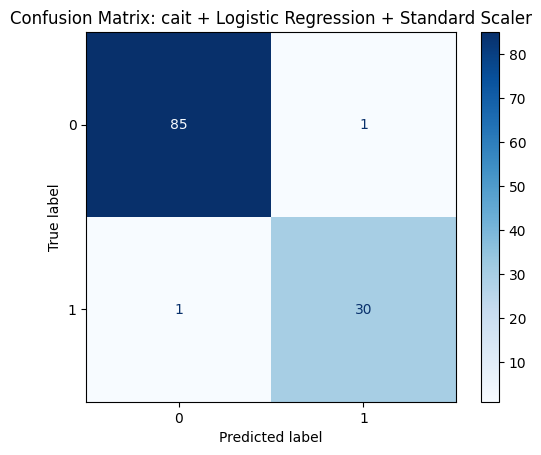

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: {model_name} + {clf_name} + {normalisasi_method}")
plt.show()

## Evaluasi Synthetic

### UMAP-TSNE

In [31]:
def drop_constant_columns(df1, df2):
    # Hanya keep kolom yang punya lebih dari 1 nilai unik di kedua dataset
    keep_cols = [col for col in df1.columns if df1[col].nunique() > 1 and df2[col].nunique() > 1]
    return df1[keep_cols], df2[keep_cols]

In [ ]:
data_real, data_fake = drop_constant_columns(data_real, data_fake)

In [14]:
def normalize_columns(df, n_tabular_cols=16):
    feature_cols = df.columns[:-n_tabular_cols]
    tabular_cols = df.columns[-n_tabular_cols:]
    new_columns = list(range(len(feature_cols))) + list(tabular_cols)
    df.columns = new_columns
    return df

In [22]:
def compute_mmd(X_real, X_synth, kernel_func=rbf_kernel, **kernel_kwargs):
    if kernel_func == rbf_kernel and "gamma" not in kernel_kwargs:
        kernel_kwargs["gamma"] = 1.0 / X_real.shape[1]
    XX = kernel_func(X_real, X_real, **kernel_kwargs)
    YY = kernel_func(X_synth, X_synth, **kernel_kwargs)
    XY = kernel_func(X_real, X_synth, **kernel_kwargs)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    return mmd

def visualize_tsne_umap(X_real, X_synth, model_name="Model", method='both'):
    # Gabungkan & label
    X_combined = pd.concat([X_real, X_synth], ignore_index=True)
    labels = np.array([0]*len(X_real) + [1]*len(X_synth))  # 0 = real, 1 = synthetic

    # Plot untuk t-SNE
    if method in ['tsne', 'both']:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne = tsne.fit_transform(X_combined)
        plt.figure(figsize=(8, 6))  # Ukuran grafik lebih besar
        scatter = sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette={0: 'blue', 1: 'orange'}, alpha=0.5)
        plt.title(f"t-SNE - {model_name}")
        
        # Menambahkan legend manual agar warna sesuai
        handles, _ = scatter.get_legend_handles_labels()
        scatter.legend(handles, ["Real", "Synthetic"], fontsize=10, markerscale=1.2, loc='upper right')
        
        plt.show()

    # Plot untuk UMAP
    if method in ['umap', 'both']:
        reducer = umap.UMAP(n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_combined)
        plt.figure(figsize=(8, 6))  # Ukuran grafik lebih besar
        scatter = sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette={0: 'blue', 1: 'orange'}, alpha=0.5)
        plt.title(f"UMAP - {model_name}")
        
        # Menambahkan legend manual agar warna sesuai
        handles, _ = scatter.get_legend_handles_labels()
        scatter.legend(handles, ["Real", "Synthetic"], fontsize=10, markerscale=1.2, loc='upper right')
        
        plt.show()

def visualize_tsne_umap_grid(gan_methods, model_names, method='both', n_tabular_cols=16):
    n_gans = len(gan_methods)
    n_models = len(model_names)
    
    fig, axes = plt.subplots(n_gans * 2, n_models, figsize=(20, 6 * n_gans))  # Grid layout

    for i, gan in enumerate(gan_methods):
        for j, model in enumerate(model_names):
            print(f'Proses: {gan} - {model}')
            
            # Path dataset sintetik
            if gan in ['copulagan', 'ctgan']:
                synth_path = f"dataset/synthetic_real/pca-85-percent/{gan}/synthetic/{model}_fake.csv"
            else:
                synth_path = f"dataset/synthetic_real/pca-85-percent/{gan}/synthetic/{model}_fake_0.csv"
                
            data_fake = pd.read_csv(synth_path)
            data_real = minority_data_dict[model]

            data_fake = data_fake.iloc[:, -n_tabular_cols:]
            data_real = data_real.iloc[:, -n_tabular_cols:]

            # Normalisasi
            data_fake = normalize_columns(data_fake, n_tabular_cols=n_tabular_cols)
            data_real = normalize_columns(data_real, n_tabular_cols=n_tabular_cols)

            # Pastikan nama kolom sama
            data_fake.columns = data_fake.columns.astype(str)
            data_real.columns = data_real.columns.astype(str)

            # Hitung MMD
            mmd_score = compute_mmd(data_real.values, data_fake.values)

            # Gabungkan data untuk visualisasi
            X_combined = pd.concat([data_real, data_fake], ignore_index=True)
            labels = np.array([0] * len(data_real) + [1] * len(data_fake))  # 0 = real, 1 = synthetic

            model_name = f"{model} ({gan})"
            colnames = ', '.join(data_real.columns[:4]) + ('...' if len(data_real.columns) > 4 else '')

            # t-SNE
            if method in ['tsne', 'both']:
                tsne = TSNE(n_components=2, perplexity=30, random_state=42)
                X_tsne = tsne.fit_transform(X_combined)
                ax = axes[2 * i, j]
                scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels,
                                          palette={0: 'blue', 1: 'orange'}, alpha=0.5, ax=ax)
                ax.set_title(f"t-SNE - {model_name}\nMMD: {mmd_score:.4f}", fontsize=10)
                handles, _ = scatter.get_legend_handles_labels()
                scatter.legend(handles, ["Real", "Synthetic"], fontsize=9, markerscale=1.2, loc='upper right')
                # Tambahkan nama kolom di bawah plot
                ax.text(0.5, -0.15, f"Columns: {colnames}", fontsize=8, ha='center', va='center', transform=ax.transAxes)

            # UMAP
            if method in ['umap', 'both']:
                reducer = umap.UMAP(n_components=2, random_state=42)
                X_umap = reducer.fit_transform(X_combined)
                ax = axes[2 * i + 1, j]
                scatter = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels,
                                          palette={0: 'blue', 1: 'orange'}, alpha=0.5, ax=ax)
                ax.set_title(f"UMAP - {model_name}\nMMD: {mmd_score:.4f}", fontsize=10)
                handles, _ = scatter.get_legend_handles_labels()
                scatter.legend(handles, ["Real", "Synthetic"], fontsize=9, markerscale=1.2, loc='upper right')
                # Tambahkan nama kolom di bawah plot
                ax.text(0.5, -0.15, f"Columns: {colnames}", fontsize=8, ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()


In [51]:
from scipy.stats import ks_2samp, wasserstein_distance

def visualize_tsne_umap_ctabgan_cait_with_stats(method='both', n_tabular_cols=16):
    gan = 'ctabgan'
    model = 'cait'

    print(f'\n=== Proses: {gan} - {model} ===')

    # Load data
    synth_path = f"dataset/synthetic_real/pca-85-percent/{gan}/synthetic/{model}_fake_0.csv"
    data_fake = pd.read_csv(synth_path)
    data_real = minority_data_dict[model]

    data_fake = data_fake.iloc[:, -n_tabular_cols:]
    data_real = data_real.iloc[:, -n_tabular_cols:]

    data_fake = normalize_columns(data_fake, n_tabular_cols=n_tabular_cols)
    data_real = normalize_columns(data_real, n_tabular_cols=n_tabular_cols)

    data_fake.columns = data_fake.columns.astype(str)
    data_real.columns = data_real.columns.astype(str)

    mmd_score = compute_mmd(data_real.values, data_fake.values)
    model_name = f"{model} ({gan})"

    X_combined = pd.concat([data_real, data_fake], ignore_index=True)
    labels = np.array([0] * len(data_real) + [1] * len(data_fake))

    # t-SNE
    if method in ['tsne', 'both']:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_tsne = tsne.fit_transform(X_combined)

        plt.figure(figsize=(6, 5))
        scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels,
                                  palette={0: 'blue', 1: 'orange'}, alpha=0.5)
        plt.title(f"t-SNE - {model_name}\nMMD: {mmd_score:.4f}")
        scatter.legend(["Real", "Synthetic"], fontsize=9, loc='upper right')
        plt.tight_layout()
        plt.show()

    # UMAP
    if method in ['umap', 'both']:
        reducer = umap.UMAP(n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_combined)

        plt.figure(figsize=(6, 5))
        scatter = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels,
                                  palette={0: 'blue', 1: 'orange'}, alpha=0.5)
        plt.title(f"UMAP - {model_name}\nMMD: {mmd_score:.4f}")
        scatter.legend(["Real", "Synthetic"], fontsize=9, loc='upper right')
        plt.tight_layout()
        plt.show()

    # Distribusi kolom dengan metrik statistik
    print(f"\nDistribusi per kolom untuk {model_name}")
    for col in data_real.columns:
        real_col = data_real[col].dropna()
        fake_col = data_fake[col].dropna()

        # Statistik
        mean_real = real_col.mean()
        mean_fake = fake_col.mean()
        std_real = real_col.std()
        std_fake = fake_col.std()

        # Plot
        plt.figure(figsize=(5, 4))
        sns.kdeplot(real_col, label='Real', fill=True, color='blue', alpha=0.5)
        sns.kdeplot(fake_col, label='Synthetic', fill=True, color='orange', alpha=0.5)
        plt.title(f"Distribusi Kolom: {col}", fontsize=12)
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.legend(fontsize=9, loc='upper right')

        # Tambahkan metrik ke plot
        # Teks statistik dalam kotak
        stat_text = (
            f"Real μ={mean_real:.3f}, σ={std_real:.3f}\n"
            f"Fake μ={mean_fake:.3f}, σ={std_fake:.3f}\n"
        )
        plt.text(
            0.98, 0.7, stat_text,
            transform=plt.gca().transAxes,
            fontsize=8,
            va='bottom', ha='right',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha=0.8)
        )

        plt.tight_layout()
        plt.show()



=== Proses: ctabgan - cait ===


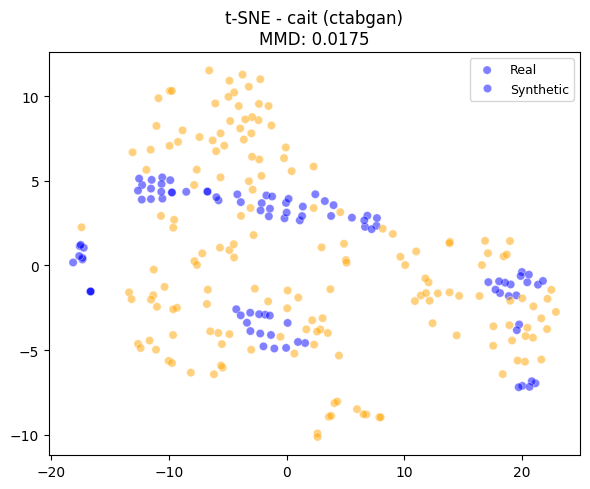

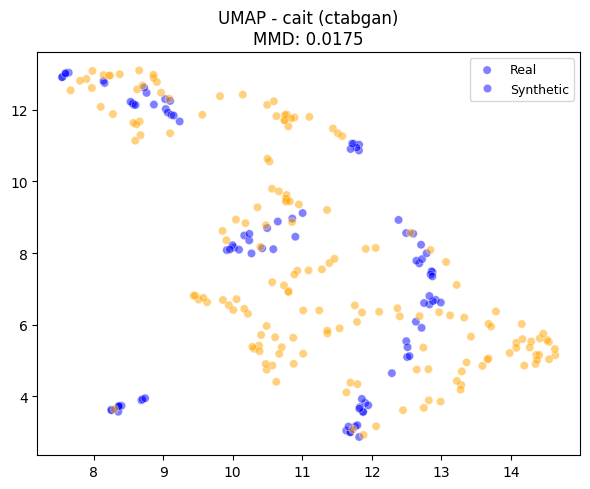


Distribusi per kolom untuk cait (ctabgan)


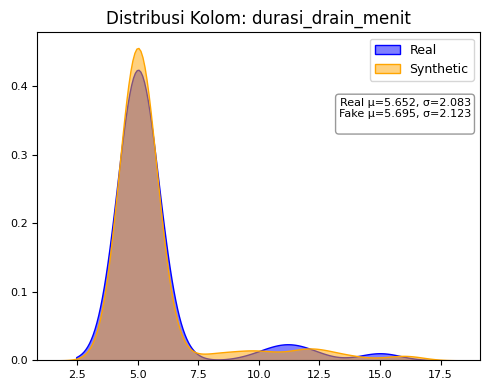

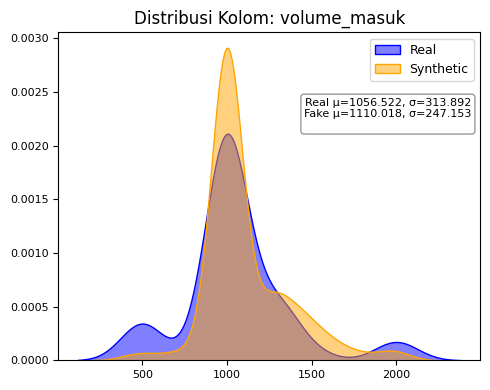

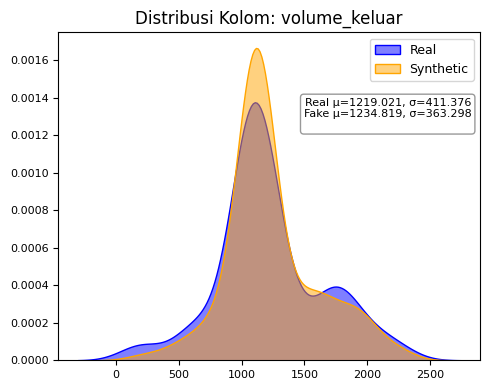

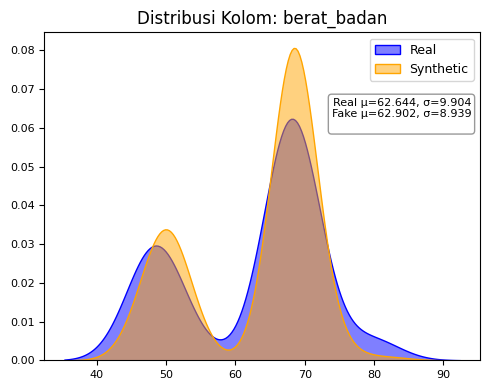

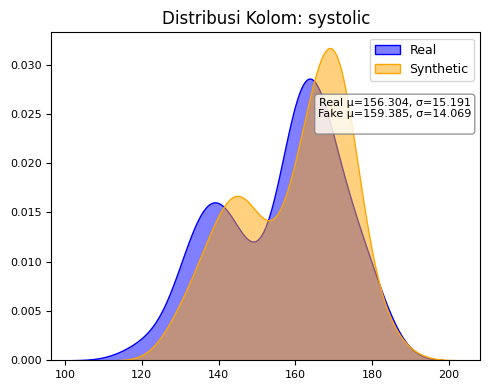

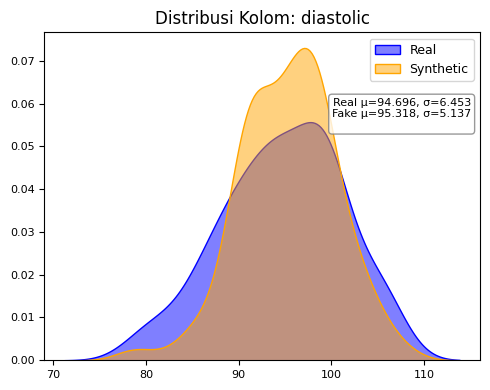

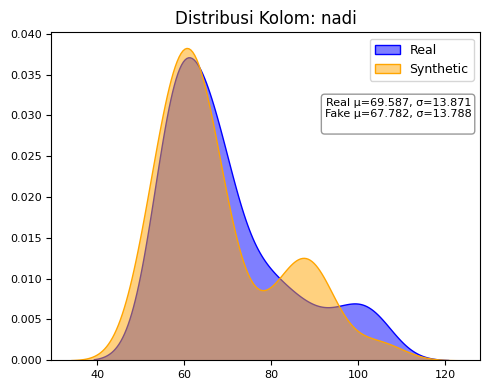

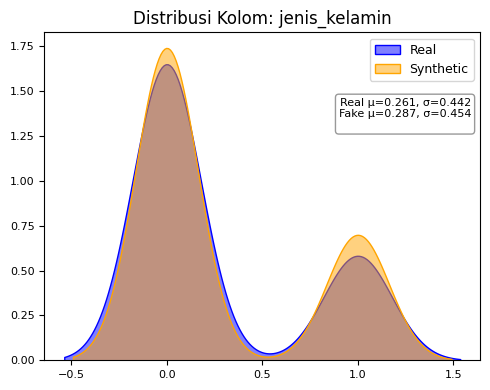

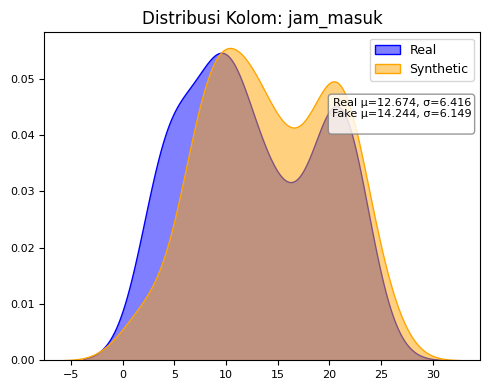

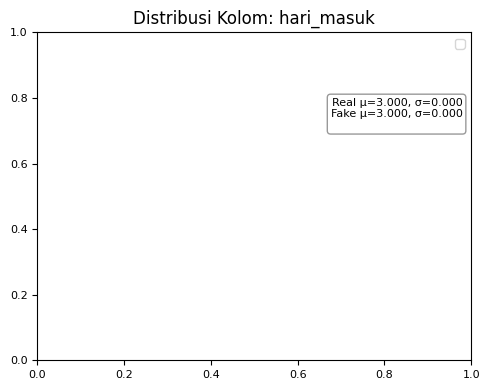

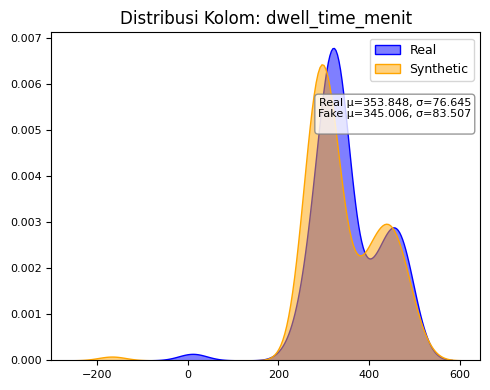

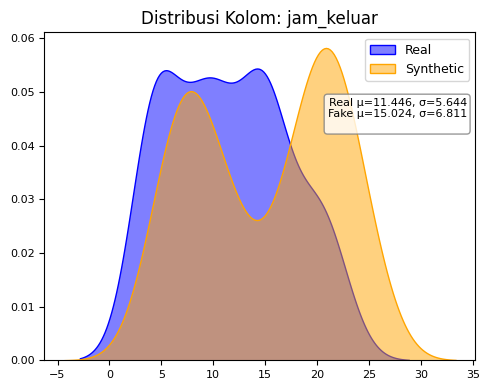

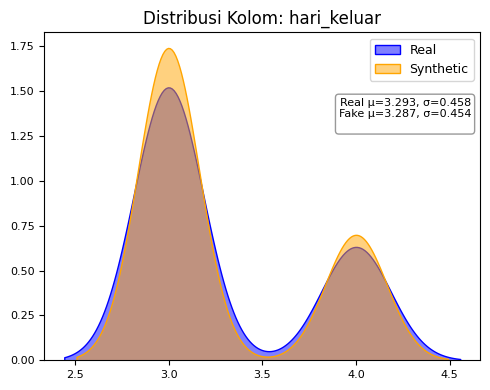

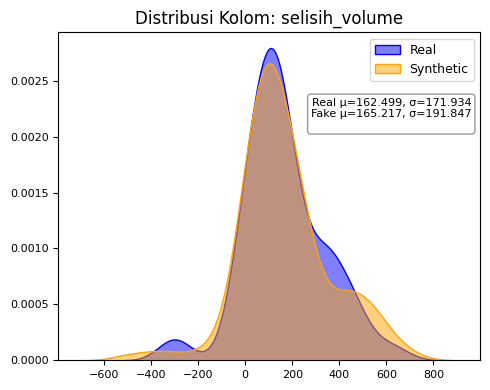

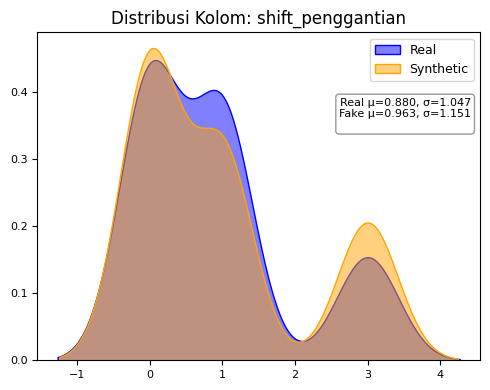

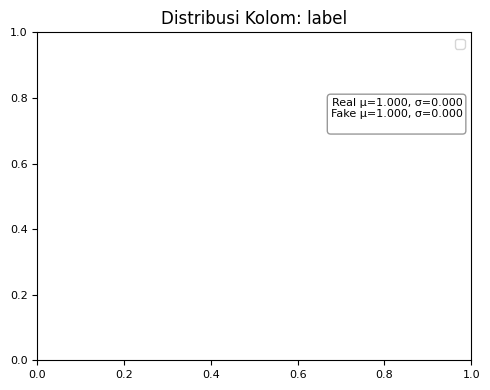

In [52]:
visualize_tsne_umap_ctabgan_cait_with_stats()

In [30]:
synth_path = f"dataset/synthetic_real/pca-85-percent/ctabgan/synthetic/cait_fake_0.csv"

data_fake = pd.read_csv(synth_path)
data_real = minority_data_dict['cait']

print(data_real['hari_masuk'].value_counts())
print(data_fake['hari_masuk'].value_counts())


hari_masuk
3.0    92
Name: count, dtype: int64
hari_masuk
3.0    164
Name: count, dtype: int64


Proses: ctabgan - cait


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

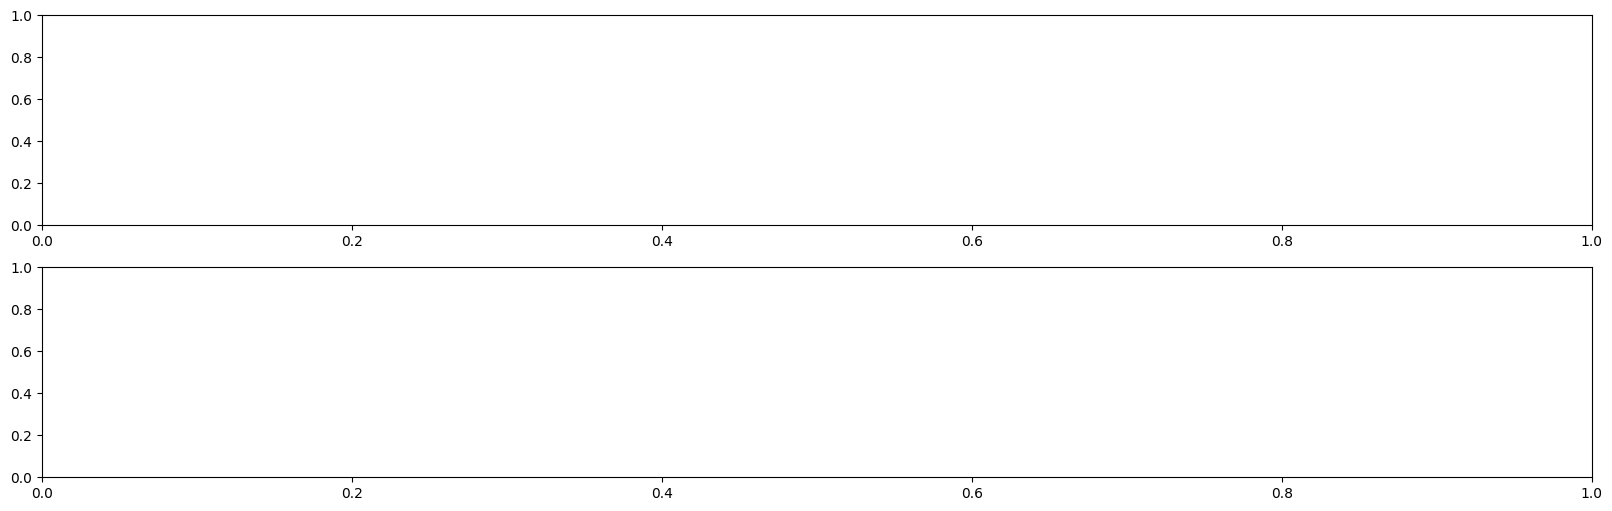

In [24]:
gan_methods = ['ctabgan']
model_names = ['cait']
visualize_tsne_umap_grid(gan_methods, model_names)

### SDV

In [16]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

gan_methods = ['copulagan', 'ctabgan', 'ctabganplus', 'ctgan']
model_names = ['swin', 'cait', 'coatnet', 'yolov9']

for i, gan in enumerate(gan_methods):
    for j, model in enumerate(model_names):
        print(f'Proses: {gan} - {model}')

        # Tentukan path ke data sintetik
        if gan in ['copulagan', 'ctgan']:
            synth_path = f"dataset/synthetic_real/pca-85-percent/{gan}/synthetic/{model}_fake.csv"
        else:
            synth_path = f"dataset/synthetic_real/pca-85-percent/{gan}/synthetic/{model}_fake_0.csv"

        # Load data
        data_fake = pd.read_csv(synth_path)
        data_real = minority_data_dict[model]

        data_real.columns = data_real.columns.astype(str)
        data_fake.columns = data_fake.columns.astype(str)


        # Deteksi metadata dari data real
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data_real)

        # Jalankan diagnostic
        diagnostic = run_diagnostic(data_real, data_fake, metadata)

        # Jalankan quality evaluation
        quality_report = evaluate_quality(data_real, data_fake, metadata)

Proses: copulagan - swin
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 98/98 [00:00<00:00, 5089.29it/s]|
Data Validity Score: 99.14%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<?, ?it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.57%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 98/98 [00:00<00:00, 2638.66it/s]|
Column Shapes Score: 61.43%

(2/2) Evaluating Column Pair Trends: |██████████| 4753/4753 [00:09<00:00, 481.94it/s]|
Column Pair Trends Score: 87.69%

Overall Score (Average): 74.56%

Proses: copulagan - cait
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 84/84 [00:00<00:00, 5244.21it/s]|
Data Validity Score: 98.46%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<?, ?it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.23%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 84/84 [00:00<00:00, 2660.92it/s]|
Column Shapes Score: 61.45%

(2/2) Eval